# **i. Introduction**

Name: Stanly Sukmajaya

Batch: RMT-036

Dataset: credit-card-information

Dataset Description: This dataset contains information about customers behaviours with using their credit cards. Columns include `Balance`, `Payments`, `Tenure`, `Purchases`, etc. 

[source](https://github.com/FTDS-assignment-bay/p1-ftds036-rmt-g6-stanlys96)

# **ii. SQL Query**

```
SELECT * FROM `ftds-hacktiv8-project.phase1_ftds_036_rmt.credit-card-information` WHERE MOD(CUST_ID, 2) = 0;
```

# **iii. Import Libraries**

The code below is all the libraries that we will use in this project.

In [89]:
import pandas as pd
import numpy as np
from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler # numerical feature scaler
from sklearn.decomposition import PCA
from scipy.stats import spearmanr # for relation analysis 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # turn off warning
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import joblib # For model saving and model inference
from sklearn.pipeline import Pipeline

# **iv. Data Loading**

In this section, we will load the data for further data exploration and modelling.

In [90]:
# Load the credit card data
credit_card_original = pd.read_csv("P1G6_Set_1_stanly.csv", index_col=0)
credit_card_information_df = credit_card_original.copy()
credit_card_information_df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0      788    16.581535              0.125      200.0               0.0   
1     1902   943.584041              0.875      103.0             103.0   
2     2322     1.979916              0.125       80.0              80.0   
3     3426   461.455720              1.000      585.0             585.0   
4     3976  1053.594730              1.000     1450.0            1450.0   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   200.0           0.0                0.125   
1                     0.0           0.0                0.125   
2                     0.0           0.0                0.125   
3                     0.0           0.0                0.125   
4                     0.0           0.0                0.125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000                             0.125   
1                       0.125                             0.000   
2                       0.125                             0.000   
3                       0.125                             0.000   
4                       0.125                             0.000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0                 0              2        1200.0   
1                     0.0                 0              1        1000.0   
2                     0.0                 0              1        1500.0   
3                     0.0                 0              1        1000.0   
4                     0.0                 0              1        1500.0   

     PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0    0.000000               NaN               0.0       8  
1  215.325023        410.484825               0.0       8  
2    0.000000               NaN               0.0       8  
3  258.032630        151.696433               0.0       8  
4  397.090516        227.143184               0.0       8

In [91]:
# Check credit_card_information_df using .info()
credit_card_information_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4475 entries, 0 to 4474
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHASES_T

There are 4 columns of `int64` type and 14 columns of `float64` type, but I suppose `CUST_ID` should not be treated as `int64` as it is the identification of credit card holders. However, we will keep it as int, as we will not use `CUST_ID` for EDA or Feature Engineering.

Columns that have missing values are `CREDIT_LIMIT` with 1 data and `MINIMUM_PAYMENTS` with 158 data.

There are 4 columns of `int64` type:
- `CUST_ID` = Identification of credit card holder
- `CASH_ADVANCE_TRX` = Number of transactions made with 'Cash in Advances'
- `PURCHASES_TRX` = Number of purchase transactions made
- `TENURE` = Tenure of credit card service for user

14 columns of `float64` type:
- `BALANCE` = Balance amount left in their account to make purchases
- `BALANCE_FREQUENCY` = How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
- `PURCHASES` = Amount of purchases made from account
- `ONEOFF_PURCHASES` = Maximum purchase amount done in one-go
- `INSTALLMENTS_PURCHASES` = Amount of purchase done in installment
- `CASH_ADVANCE` = Cash in advance given by the user
- `PURCHASES_FREQUENCY` = How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
- `ONEOFF_PURCHASES_FREQUENCY` = How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
- `PURCHASES_INSTALLMENTS_FREQUENCY` = How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
- `CASH_ADVANCE_FREQUENCY` = How frequently the cash in advance being paid
- `CREDIT_LIMIT` = Limit of credit card for user
- `PAYMENTS` = Amount of payment done by user
- `MINIMUM_PAYMENTS` = Minimum amount of payments made by user
- `PRC_FULL_PAYMENT` = Percent of full payment paid by user

**Check duplicates in credit_card_information_df**

Let's check for duplicated data

In [92]:
credit_card_information_df.duplicated().sum()

0

In [93]:
credit_card_information_df

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0         788    16.581535           0.125000     200.00              0.00   
1        1902   943.584041           0.875000     103.00            103.00   
2        2322     1.979916           0.125000      80.00             80.00   
3        3426   461.455720           1.000000     585.00            585.00   
4        3976  1053.594730           1.000000    1450.00           1450.00   
...       ...          ...                ...        ...               ...   
4470     4630  1079.008102           1.000000       0.00              0.00   
4471     8614   809.582978           0.909091       0.00              0.00   
4472     4296  3386.490883           1.000000     560.98            427.22   
4473     4476  4840.545574           1.000000    1595.93           1595.93   
4474     3564  1977.007090           1.000000    1032.04            226.90   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                     200.00      0.000000             0.125000   
1                       0.00      0.000000             0.125000   
2                       0.00      0.000000             0.125000   
3                       0.00      0.000000             0.125000   
4                       0.00      0.000000             0.125000   
...                      ...           ...                  ...   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000000                          0.125000   
1                       0.125000                          0.000000   
2                       0.125000                          0.000000   
3                       0.125000                          0.000000   
4                       0.125000                          0.000000   
...                          ...                               ...   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              2        1200.0   
1                   0.000000                 0              1        1000.0   
2                   0.000000                 0              1        1500.0   
3                   0.000000                 0              1        1000.0   
4                   0.000000                 0              1        1500.0   
...                      ...               ...            ...           ...   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                17             25        6000.0   
4474                0.545455                21             17        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0        0.000000               NaN          0.000000       8  
1      215.325023        410.484825          0.000000       8  
2        0.000000               NaN          0.000000       8  
3      258.032630        151.696433          0.000000       8  
4      397.090516        227.143184          0.000000       8  
...           ...               ...               ...     ...  
4470  1379.635287        2

**Summary of credit_card_information_df**:
- There are 4 integer and 14 float columns
- The dataset consists of 4475 rows and 18 columns
- The columns `CREDIT_LIMIT` has 1 missing value, and `MINIMUM_PAYMENTS` has 158 missing values
- There are no duplicated values

# **v. Exploratory Data Analysis (EDA)**

We will do the first EDA before the final process of clustering. Later, we will do another EDA to compare between the before and after of the Feature Engineering and Clustering process.

**Answering the questions**

1. Apakah terdapat pola antara pengaruh TENURE dengan variabel PURCHASES, BALANCE, dan PAYMENTS ? Buatlah visualisasi yang menunjukkan hubungan ini berikan rekomendasi bisnis untuk tim marketing mengenai hal ini.

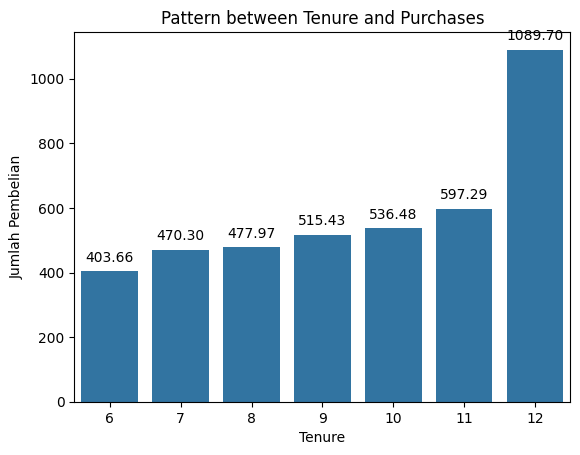

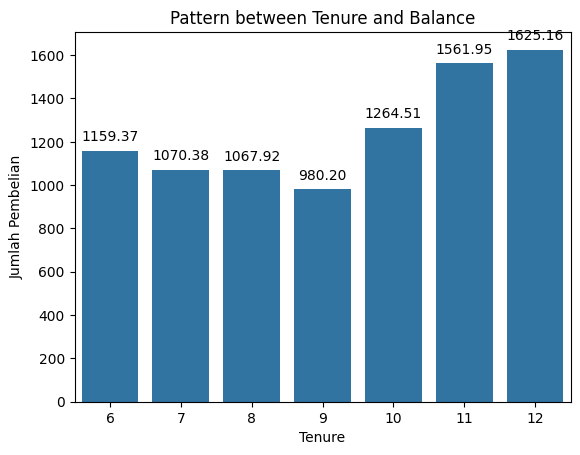

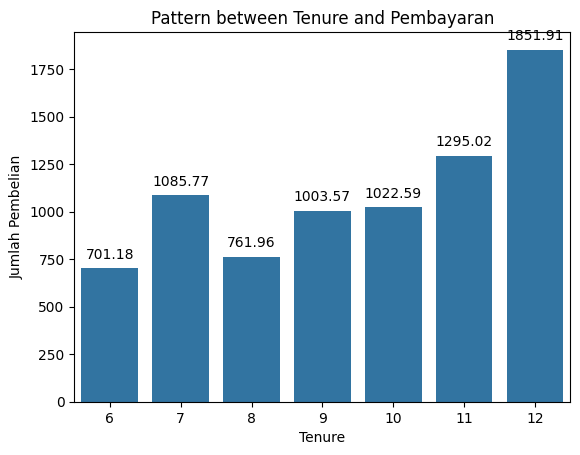

In [94]:
# Visualisasi hubungan antara tenure dan purchases
bar_plot = sns.barplot(x='TENURE', y='PURCHASES', ci=None, data=credit_card_information_df)
plt.title('Pattern between Tenure and Purchases')
plt.xlabel('Tenure')
plt.ylabel('Jumlah Pembelian')
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=10, color='black', 
                      xytext=(0, 5),  # Offset text by 5 points
                      textcoords='offset points')
plt.show()

# Visualisasi hubungan antara tenure dan balance
bar_plot = sns.barplot(x='TENURE', y='BALANCE', ci=None, data=credit_card_information_df)
plt.title('Pattern between Tenure and Balance')
plt.xlabel('Tenure')
plt.ylabel('Jumlah Pembelian')
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=10, color='black', 
                      xytext=(0, 5),  # Offset text by 5 points
                      textcoords='offset points')
plt.show()

# Visualisasi hubungan antara tenure dan payments
bar_plot = sns.barplot(x='TENURE', y='PAYMENTS', ci=None, data=credit_card_information_df)
plt.title('Pattern between Tenure and Pembayaran')
plt.xlabel('Tenure')
plt.ylabel('Jumlah Pembelian')
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=10, color='black', 
                      xytext=(0, 5),  # Offset text by 5 points
                      textcoords='offset points')
plt.show()

From the bar plots visualised above, we can clearly see that the tenure with value 12 has the highest values in all three columns (`PURCHASES`, `BALANCE` and `PAYMENTS`). Therefore, we can conclude that we can recommend giving more advantages to the customers if they opt to choose the 12 months tenure. We can create targeted offers and promotions specifically for customers approaching their 12-month tenure to encourage continued engagement and loyalty. 

2. Apakah nasabah dengan CREDIT_LIMIT yang tinggi cenderung lebih sering melakukan pembelian ? Lakukanlah analisis untuk mengetahui bagaimana CREDIT_LIMIT mempengaruhi frekuensi pembelian (PURCHASES_FREQUENCY). Buatlah visualisasi yang menunjukkan hubungan ini berikan rekomendasi bisnis untuk tim marketing mengenai hal ini.

The correlation between CREDIT_LIMIT and PURCHASES_FREQUENCY is: 0.13282375229180077


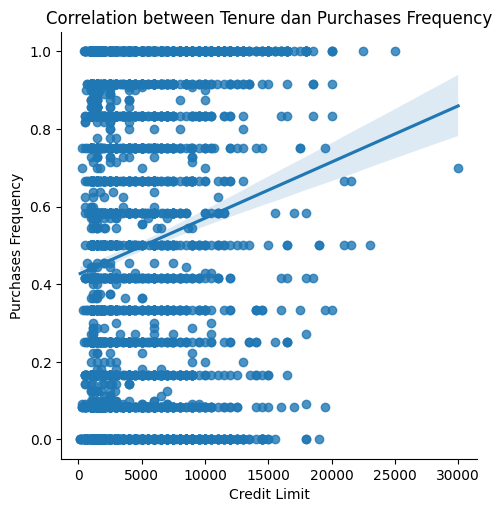

In [95]:
print("The correlation between CREDIT_LIMIT and PURCHASES_FREQUENCY is: " + str(credit_card_information_df["CREDIT_LIMIT"].corr(credit_card_information_df["PURCHASES_FREQUENCY"])))
sns.lmplot(x='CREDIT_LIMIT', y='PURCHASES_FREQUENCY', data=credit_card_information_df)
plt.title('Correlation between Tenure dan Purchases Frequency')
plt.xlabel('Credit Limit')
plt.ylabel('Purchases Frequency')

plt.show()

From this plot and the correlation value, we can see that there is a weak correlation between `CREDIT_LIMIT` and `PURCHASES_FREQUENCY`. However, there is an upward-sloping line which indicates that as `CREDIT_LIMIT` increases, `PURCHASES_FREQUENCY` tends to increase as well.

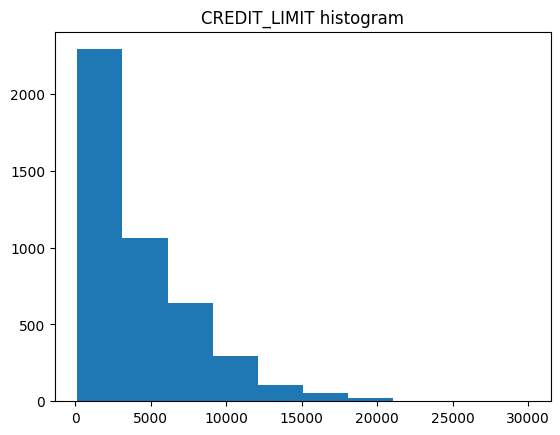

In [96]:
correlation_column = 'CREDIT_LIMIT'
other_correlation_column = 'PURCHASES_FREQUENCY'

plt.hist(credit_card_information_df[correlation_column]);
plt.title(f"{correlation_column} histogram");

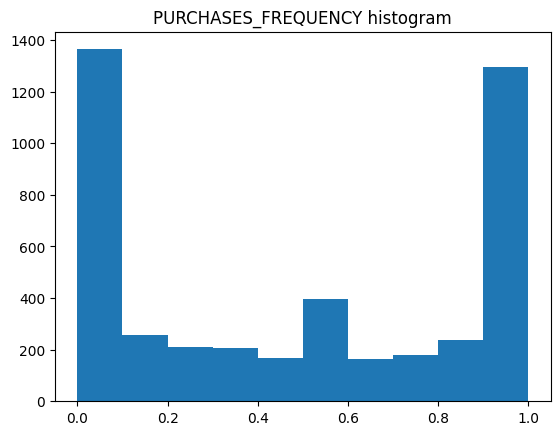

In [97]:
plt.hist(credit_card_information_df[other_correlation_column]);
plt.title(f"{other_correlation_column} histogram");

From the 2 distributions above, we can see that the 2 are not normal distributions, so we will use `spearmanr` to conduct correlation testing.

In [98]:
# Pearson correlation test
corr_r, pval_p = spearmanr(credit_card_information_df[correlation_column].fillna(credit_card_information_df[correlation_column].median()), credit_card_information_df[other_correlation_column])

print(f"Spearman correlation coefficient: {corr_r}")
print(f"P-value: {pval_p}")

if pval_p < 0.05:
    print(f"There is a significant correlation between {correlation_column} and {other_correlation_column}.")
else:
    print(f"There is no significant correlation between {correlation_column} and {other_correlation_column}.")

Spearman correlation coefficient: 0.12275400852875558
P-value: 1.7139081629977948e-16
There is a significant correlation between CREDIT_LIMIT and PURCHASES_FREQUENCY.


Conclusion: Even though the correlation is weak, the significant p-value suggests that there is a real, albeit weak, relationship between the two variables.

# **vi. Feature Transformation**

> This section contains the data preparation process for model training, such as handling outliers and handling missing values.

## 1. Handling Outliers

Checking the skewness of all columns, and look at all unique values, in case a categorical column disguises as numerical.

In [99]:
# Check Skewness

all_columns = credit_card_information_df.columns.to_list()

df_col = []
normal_col = []
skewed_col = []

for col in all_columns:
  skewness = round(credit_card_information_df[col].skew(), 1)
  unique_values = len(credit_card_information_df[col].unique())
  df_col.append([col, skewness, "normal" if skewness <= 0.5 and skewness >= -0.5 else "skewed", unique_values])
  if skewness <= 0.5 and skewness >= -0.5 and skewness != 0:
    normal_col.append(col)
  elif skewness > 0 or skewness < 0:
    skewed_col.append(col)

skewness = pd.DataFrame(columns=['Column', 'Skewness', 'Distribution', 'Total Unique Values'], data= df_col)
skewness

Column  Skewness Distribution  \
0                            CUST_ID       0.0       normal   
1                            BALANCE       2.5       skewed   
2                  BALANCE_FREQUENCY      -2.0       skewed   
3                          PURCHASES       9.0       skewed   
4                   ONEOFF_PURCHASES      10.1       skewed   
5             INSTALLMENTS_PURCHASES       8.1       skewed   
6                       CASH_ADVANCE       4.7       skewed   
7                PURCHASES_FREQUENCY       0.1       normal   
8         ONEOFF_PURCHASES_FREQUENCY       1.5       skewed   
9   PURCHASES_INSTALLMENTS_FREQUENCY       0.5       normal   
10            CASH_ADVANCE_FREQUENCY       1.8       skewed   
11                  CASH_ADVANCE_TRX       4.8       skewed   
12                     PURCHASES_TRX       4.5       skewed   
13                      CREDIT_LIMIT       1.5       skewed   
14                          PAYMENTS       6.0       skewed   
15                  MINIMUM_PAYMENTS      12.4       skewed   
16                  PRC_FULL_PAYMENT       1.9       skewed   
17                            TENURE      -2.9       skewed   

    Total Unique Values  
0                  4475  
1                  4439  
2                    42  
3                  3218  
4                  2073  
5                  2357  
6                  2155  
7                    47  
8                    44  
9                    47  
10                   46  
11                   55  
12                  147  
13                  154  
14                 4350  
15                 4318  
16                   47  
17                    7

Only `PURCHASES_FREQUENCY` and `PURCHASES_INSTALLMENTS_FREQUENCY` have normal distributions. `TENURE` has 7 unique values, which can be further investigated whether it could be categorical or not. Looking at the description, which means it's the length of time of the credit card service, we can safely conclude that it is a numerical column.

In [100]:
print(f"Columns with normal distributions: {normal_col}")
print(f"Columns with skewed distributions: {skewed_col}")

Columns with normal distributions: ['PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY']
Columns with skewed distributions: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


Now we will create a dataframe to see which columns have high outlier percentages.

In [101]:
# Get upper, lower boundaries and percentage of outliers
column = []
lower_bound = []
upper_bound = []
percent_total_outlier = []

for row in range(0, len(skewness)):
  col = skewness['Column'][row]

  # Checking upper and lower boundary, distance = 3
  if skewness['Distribution'][row] == 'skewed': # Tukey's Rule
    iqr = credit_card_information_df[col].quantile(0.75) - credit_card_information_df[col].quantile(0.25)
    lower_boundary = credit_card_information_df[col].quantile(0.25) - (iqr * 3)
    upper_boundary = credit_card_information_df[col].quantile(0.75) + (iqr * 3)
  else:
    lower_boundary = credit_card_information_df[col].mean() - 3 * credit_card_information_df[col].std()
    upper_boundary = credit_card_information_df[col].mean() + 3 * credit_card_information_df[col].std()
  
  # Append to list
  column.append(col)
  lower_bound.append(lower_boundary)
  upper_bound.append(upper_boundary)
  totout = ((len(credit_card_information_df[credit_card_information_df[col] > upper_boundary]) / len(credit_card_information_df) * 100) + (len(credit_card_information_df[credit_card_information_df[col] < lower_boundary]) / len(credit_card_information_df) * 100))
  percent_total_outlier.append(totout)

outliers = pd.DataFrame({
    'column': column,
    'upper_boundary': [round(upper_bound,2) for upper_bound in upper_bound],
    'lower_boundary': [round(lower_bound,2) for lower_bound in lower_bound],
    'percentage_total_outlier': [round(percent_total_outlier,2) for percent_total_outlier in percent_total_outlier]
})

outliers

column  upper_boundary  lower_boundary  \
0                            CUST_ID        12227.79        -3275.79   
1                            BALANCE         7836.47        -5645.41   
2                  BALANCE_FREQUENCY            1.33            0.56   
3                          PURCHASES         4370.36        -3207.66   
4                   ONEOFF_PURCHASES         2321.28        -1740.96   
5             INSTALLMENTS_PURCHASES         1937.02        -1452.76   
6                       CASH_ADVANCE         4394.28        -3295.71   
7                PURCHASES_FREQUENCY            1.69           -0.71   
8         ONEOFF_PURCHASES_FREQUENCY            1.33           -1.00   
9   PURCHASES_INSTALLMENTS_FREQUENCY            1.56           -0.83   
10            CASH_ADVANCE_FREQUENCY            0.73           -0.55   
11                  CASH_ADVANCE_TRX           16.00          -12.00   
12                     PURCHASES_TRX           65.00          -47.00   
13                      CREDIT_LIMIT        19500.00       -12000.00   
14                          PAYMENTS         6413.22        -4127.05   
15                  MINIMUM_PAYMENTS         2812.14        -1811.93   
16                  PRC_FULL_PAYMENT            0.67           -0.50   
17                            TENURE           12.00           12.00   

    percentage_total_outlier  
0                       0.00  
1                       2.28  
2                      13.01  
3                       4.07  
4                       6.23  
5                       4.11  
6                       5.47  
7                       0.00  
8                       0.00  
9                       0.00  
10                      2.35  
11                      4.00  
12                      3.73  
13                      0.31  
14                      4.38  
15                      4.49  
16                     10.30  
17                     14.93

Checking for all columns that have outliers above 5%.

In [102]:
cols_to_cap = []
for index, row in outliers.iterrows():
    if row["percentage_total_outlier"] >= 5:
        cols_to_cap.append(row["column"])

cols_to_cap

['BALANCE_FREQUENCY',
 'ONEOFF_PURCHASES',
 'CASH_ADVANCE',
 'PRC_FULL_PAYMENT',
 'TENURE']

We will do outlier handling for these 5 columns: ['`BALANCE_FREQUENCY`', '`ONEOFF_PURCHASES`', '`CASH_ADVANCE`', '`PRC_FULL_PAYMENT`', '`TENURE`']

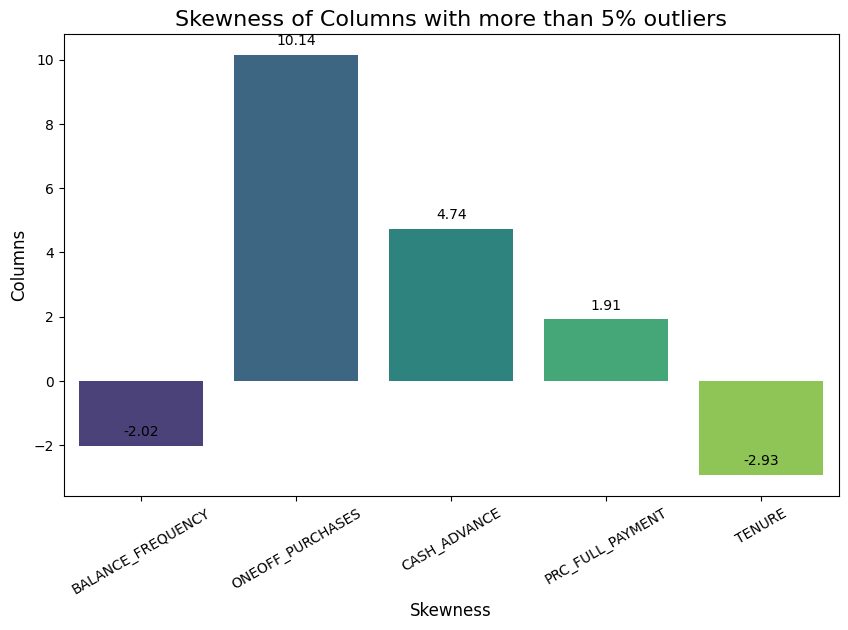

In [103]:
skewness_data = pd.DataFrame({
    'Column': cols_to_cap,
    'Skewness': [credit_card_information_df[the_col].skew() for the_col in cols_to_cap]
})

# Set up the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Column', y='Skewness', data=skewness_data, palette='viridis')

# Set titles and labels
plt.title('Skewness of Columns with more than 5% outliers', fontsize=16)
plt.xlabel('Skewness', fontsize=12)
plt.ylabel('Columns', fontsize=12)
plt.xticks(rotation=30) 
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=10, color='black', 
                      xytext=(0, 5),  # Offset text by 5 points
                      textcoords='offset points')

# Show the plot
plt.show()

In [104]:
winsoriser = Winsorizer(capping_method='quantiles',
                            tail='both',
                            fold=0.05,
                            variables=cols_to_cap,
                            missing_values='ignore')

credit_card_information_df = winsoriser.fit_transform(credit_card_information_df)

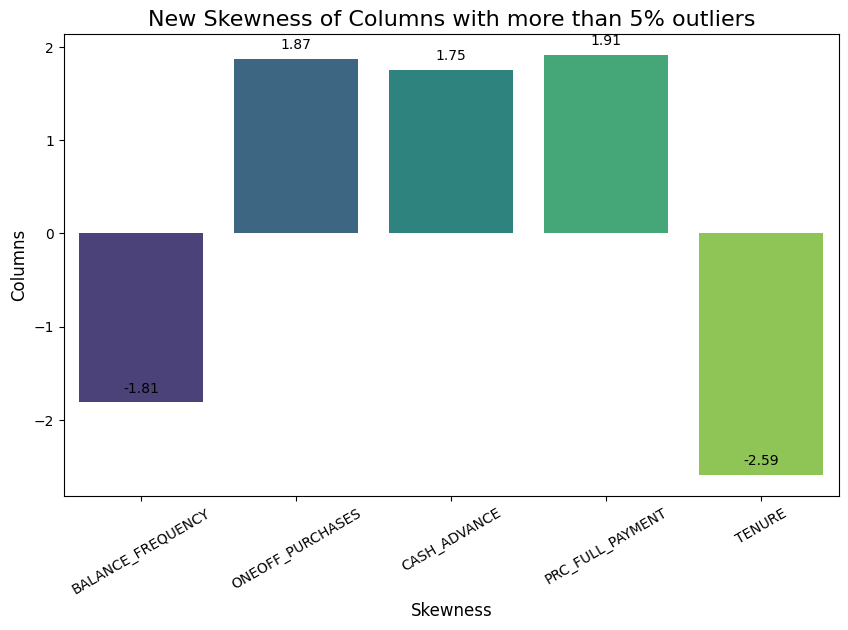

In [105]:
skewness_data = pd.DataFrame({
    'Column': cols_to_cap,
    'Skewness': [credit_card_information_df[the_col].skew() for the_col in cols_to_cap]
})

# Set up the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Column', y='Skewness', data=skewness_data, palette='viridis')

# Set titles and labels
plt.title('New Skewness of Columns with more than 5% outliers', fontsize=16)
plt.xlabel('Skewness', fontsize=12)
plt.ylabel('Columns', fontsize=12)
plt.xticks(rotation=30) 
for p in bar_plot.patches:
    bar_plot.annotate(f'{p.get_height():.2f}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', 
                      fontsize=10, color='black', 
                      xytext=(0, 5),  # Offset text by 5 points
                      textcoords='offset points')

# Show the plot
plt.show()

We can see that after capping using `Winsorizer`, the skewness of the 5 columns have dropped.

## 2. Handling Missing Values

In [106]:
credit_card_information_df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    158
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [107]:
print("MINIMUM_PAYMENTS has skewness of: " + str(credit_card_information_df["MINIMUM_PAYMENTS"].skew()))
print("CREDIT_LIMIT has skewness of: " + str(credit_card_information_df["CREDIT_LIMIT"].skew()))

MINIMUM_PAYMENTS has skewness of: 12.357860274482807
CREDIT_LIMIT has skewness of: 1.5450779677462632


We will use `median` imputer for `MINIMUM_PAYMENTS` as it is highly skewed, and `mean` for `CREDIT_LIMIT`

In [108]:
mean_imputer = SimpleImputer(strategy='median')
credit_card_information_df["MINIMUM_PAYMENTS"] = mean_imputer.fit_transform(credit_card_information_df[["MINIMUM_PAYMENTS"]])

In [109]:
median_imputer = SimpleImputer(strategy='mean')
credit_card_information_df["CREDIT_LIMIT"] = mean_imputer.fit_transform(credit_card_information_df[["CREDIT_LIMIT"]])

In [110]:
credit_card_information_df.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

Now there are no missing values.

# vii. Feature Engineering

> This section contains the data preparation process for model training, such as scaling and dimensionality reduction.

Drop the column `CUST_ID` as it is not really a numerical column. We will use it again after clustering.

In [111]:
credit_card_df = credit_card_information_df.drop("CUST_ID", axis=1)
credit_card_df

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0       16.581535           0.272727     200.00              0.00   
1      943.584041           0.875000     103.00            103.00   
2        1.979916           0.272727      80.00             80.00   
3      461.455720           1.000000     585.00            585.00   
4     1053.594730           1.000000    1450.00           1450.00   
...           ...                ...        ...               ...   
4470  1079.008102           1.000000       0.00              0.00   
4471   809.582978           0.909091       0.00              0.00   
4472  3386.490883           1.000000     560.98            427.22   
4473  4840.545574           1.000000    1595.93           1595.93   
4474  1977.007090           1.000000    1032.04            226.90   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                     200.00      0.000000             0.125000   
1                       0.00      0.000000             0.125000   
2                       0.00      0.000000             0.125000   
3                       0.00      0.000000             0.125000   
4                       0.00      0.000000             0.125000   
...                      ...           ...                  ...   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000000                          0.125000   
1                       0.125000                          0.000000   
2                       0.125000                          0.000000   
3                       0.125000                          0.000000   
4                       0.125000                          0.000000   
...                          ...                               ...   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              2        1200.0   
1                   0.000000                 0              1        1000.0   
2                   0.000000                 0              1        1500.0   
3                   0.000000                 0              1        1000.0   
4                   0.000000                 0              1        1500.0   
...                      ...               ...            ...           ...   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                17             25        6000.0   
4474                0.545455                21             17        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0        0.000000        309.854995          0.000000       8  
1      215.325023        410.484825          0.000000       8  
2        0.000000        309.854995          0.000000       8  
3      258.032630        151.696433          0.000000       8  
4      397.090516        227.143184          0.000000       8  
...           ...               ...               ...     ...  
4470  1379.635287        271.364415          0.090909      11  
4471  4372.148648        241.645387          0.090909      11  
4472  1039

Here we will scale the numerical columns:

For columns with normal distributions, we will use StandardScaler, and for skewed data, we will use MinMaxScaler.

In [112]:
standard_scaler = StandardScaler()
scaled_normal = pd.DataFrame(standard_scaler.fit_transform(credit_card_df[normal_col]), columns=normal_col)
scaled_normal.head()

PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY
0            -0.913195                         -0.604061
1            -0.913195                         -0.918691
2            -0.913195                         -0.918691
3            -0.913195                         -0.918691
4            -0.913195                         -0.918691

In [113]:
minmax_scaler = MinMaxScaler()
scaled_skewed = pd.DataFrame(minmax_scaler.fit_transform(credit_card_df[skewed_col]), columns=skewed_col)
scaled_skewed.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  0.000871           0.000000   0.004078          0.000000   
1  0.049550           0.828125   0.002100          0.038977   
2  0.000104           0.000000   0.001631          0.030274   
3  0.024232           1.000000   0.011929          0.221376   
4  0.055327           1.000000   0.029568          0.548711   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  ONEOFF_PURCHASES_FREQUENCY  \
0                0.008889           0.0                       0.000   
1                0.000000           0.0                       0.125   
2                0.000000           0.0                       0.125   
3                0.000000           0.0                       0.125   
4                0.000000           0.0                       0.125   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                     0.0               0.0       0.005587      0.035176   
1                     0.0               0.0       0.002793      0.028476   
2                     0.0               0.0       0.002793      0.045226   
3                     0.0               0.0       0.002793      0.028476   
4                     0.0               0.0       0.002793      0.045226   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0  0.000000          0.005076               0.0     0.0  
1  0.004588          0.006725               0.0     0.0  
2  0.000000          0.005076               0.0     0.0  
3  0.005498          0.002485               0.0     0.0  
4  0.008461          0.003721               0.0     0.0

In [114]:
scaled_df = pd.concat([scaled_normal, scaled_skewed], axis=1)
scaled_df

PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY   BALANCE  \
0               -0.913195                         -0.604061  0.000871   
1               -0.913195                         -0.918691  0.049550   
2               -0.913195                         -0.918691  0.000104   
3               -0.913195                         -0.918691  0.024232   
4               -0.913195                         -0.918691  0.055327   
...                   ...                               ...       ...   
4470            -1.225829                         -0.918691  0.056661   
4471            -1.225829                         -0.918691  0.042513   
4472             1.275240                         -0.003405  0.177833   
4473            -0.088981                         -0.918691  0.254188   
4474             1.047870                          1.140706  0.103817   

      BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
0              0.000000   0.004078          0.000000                0.008889   
1              0.828125   0.002100          0.038977                0.000000   
2              0.000000   0.001631          0.030274                0.000000   
3              1.000000   0.011929          0.221376                0.000000   
4              1.000000   0.029568          0.548711                0.000000   
...                 ...        ...               ...                     ...   
4470           1.000000   0.000000          0.000000                0.000000   
4471           0.875000   0.000000          0.000000                0.000000   
4472           1.000000   0.011439          0.161669                0.005945   
4473           1.000000   0.032544          0.603934                0.000000   
4474           1.000000   0.021045          0.085864                0.035784   

      CASH_ADVANCE  ONEOFF_PURCHASES_FREQUENCY  CASH_ADVANCE_FREQUENCY  \
0         0.000000                    0.000000                0.000000   
1         0.000000                    0.125000                0.000000   
2         0.000000                    0.125000                0.000000   
3         0.000000                    0.125000                0.000000   
4         0.000000                    0.125000                0.000000   
...            ...                         ...                     ...   
4470      0.275924                    0.000000                0.467533   
4471      0.836744                    0.000000                0.467533   
4472      0.439909                    0.727273                0.467533   
4473      0.954961                    0.454545                0.467533   
4474      0.949833                    0.090909                0.467533   

      CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  PAYMENTS  \
0             0.000000       0.005587      0.035176  0.000000   
1             0.000000       0.002793      0.028476  0.004588   
2             0.000000       0.002793      0.045226  0.000000   
3             0.000000       0.002793      0.028476  0.005498   
4             0.000000       0.002793      0.045226  0.008461   
...                ...            ...           ...       ...   
4470          0.081818       0.000000      0.035176  0.029397   
4471          0.063636       0.000000      0.134003  0.093162   
4472          0.081818       0.055866      0.333333  0.022139   
4473          0.154545       0.069832      0.195980  0.019302   
4474          0.190909       0.047486      0.128978  0.065126   

      MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0             0.005076          0.000000    0.00  
1             0.006725          0.000000    0.00  
2             0.005076          0.000000    0.00  
3             0.002485          0.000000    0.00  
4             0.003721          0.000000    0.00  
...                ...               ...     ...  
4470          0.004446          0.090909    0.75  
4471          0.003959          0.090909    0.75  
4472          0.014517          0.00000

# **ix. Model Definition**

> This section contains model that we will use, including dimensionality reduction, elbow method and silhouette plot & score.

## 1. Dimensionality Reduction

All the columns are scaled, now we are ready to do Dimensionality Reduction.

In [115]:
pca = PCA()
pca.fit(scaled_df)

PCA()

Text(0, 0.5, 'Eigenvalues')

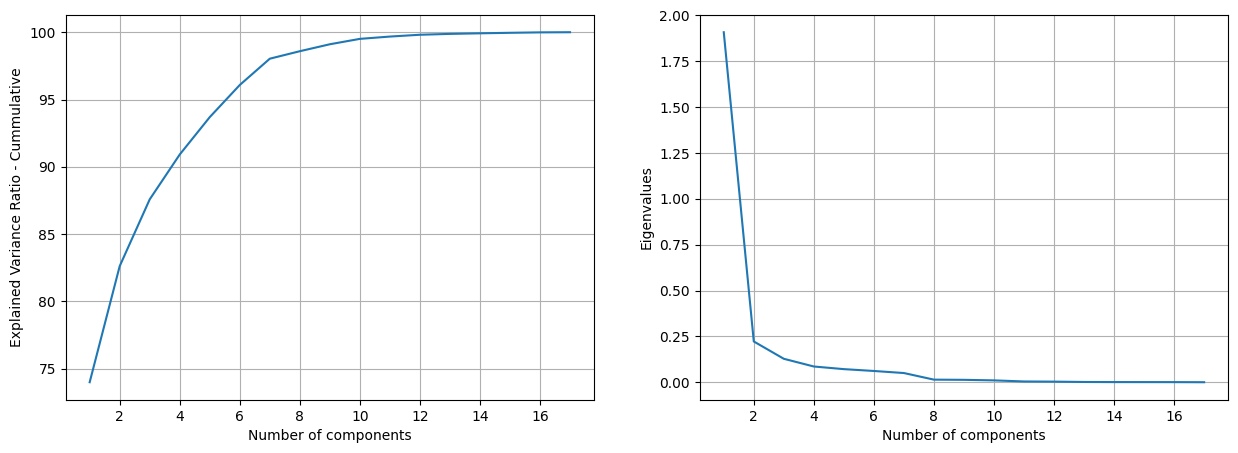

In [116]:
# Plot the Cummulative of Explained Variance Ratio
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.grid(visible=True)
plt.plot(range(1, 18), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained Variance Ratio - Cummulative')

# Plot the Eigenvalues
plt.subplot(1, 2, 2)
plt.grid(visible=True)
plt.plot(range(1, 18), pca.explained_variance_ )
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')

From the plots above, we can see that if we want to retain more than 95% of the information, we only need 6 components.

In [117]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
num_features = np.argmax(cumsum >= 0.95) + 1
num_features

6

In [118]:
# Let's train the model with 95 % of the original dataset information

pca = PCA(n_components=num_features)
pca.fit(scaled_df)

scaled_pca = pca.transform(scaled_df)
scaled_pca[:5]

array([[-1.1432738 ,  0.35751599, -0.6679089 , -0.67455377, -0.55239611,
        -0.41887728],
       [-1.30889755,  0.00555321, -0.21576679, -0.42328132, -0.66598094,
         0.15156051],
       [-1.35009518,  0.09969695, -0.68962044, -0.68233103, -0.57995508,
        -0.39765433],
       [-1.2883693 , -0.08931229, -0.11364057, -0.36732981, -0.64527432,
         0.20140689],
       [-1.26714115, -0.22841672, -0.08581848, -0.36608965, -0.56710012,
         0.0782471 ]])

## 2. Elbow Method

We will use Elbow Method to determine how many clusters are best to use for our clustering model.

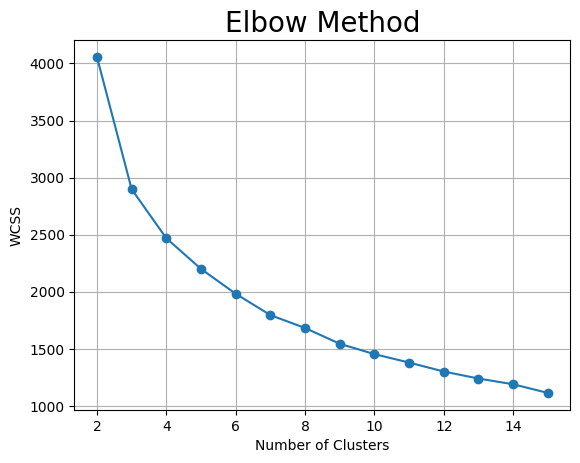

In [119]:
wcss = []
random_state = 10
max_cluster = 15
for i in range(2, max_cluster+1):
    km = KMeans(n_clusters = i,
                init = 'k-means++',
                max_iter = 300,
                n_init = 10,
                random_state = random_state)
    km.fit(scaled_pca)
    wcss.append(km.inertia_)

plt.plot(range(2, max_cluster+1), wcss, marker ="o")
plt.grid(visible=True)
plt.title('Elbow Method', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

As can be seen from the plot above, 4 is the ideal cluster, as after the number 4, the plot is decreasing in a steady manner, and not too much as like from 2 to 3, and 3 to 4.

## 3. Silhouette plot & score

In [120]:
# Function to create Silhouette Plot
def plot_silhouette(range_n_clusters, X, random_state):
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 4)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_

        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

For n_clusters = 2 The average silhouette_score is : 0.5315862473166652
For n_clusters = 3 The average silhouette_score is : 0.4334086262110046
For n_clusters = 4 The average silhouette_score is : 0.4329348853473156
For n_clusters = 5 The average silhouette_score is : 0.36455762537513847
For n_clusters = 6 The average silhouette_score is : 0.33278529013145447
For n_clusters = 7 The average silhouette_score is : 0.325233261638043
For n_clusters = 8 The average silhouette_score is : 0.33130742805247654
For n_clusters = 9 The average silhouette_score is : 0.31005678636234946
For n_clusters = 10 The average silhouette_score is : 0.30720168802820913
For n_clusters = 11 The average silhouette_score is : 0.3124512399725945
For n_clusters = 12 The average silhouette_score is : 0.31692290784047716
For n_clusters = 13 The average silhouette_score is : 0.31203983181815625
For n_clusters = 14 The average silhouette_score is : 0.31928273144896485


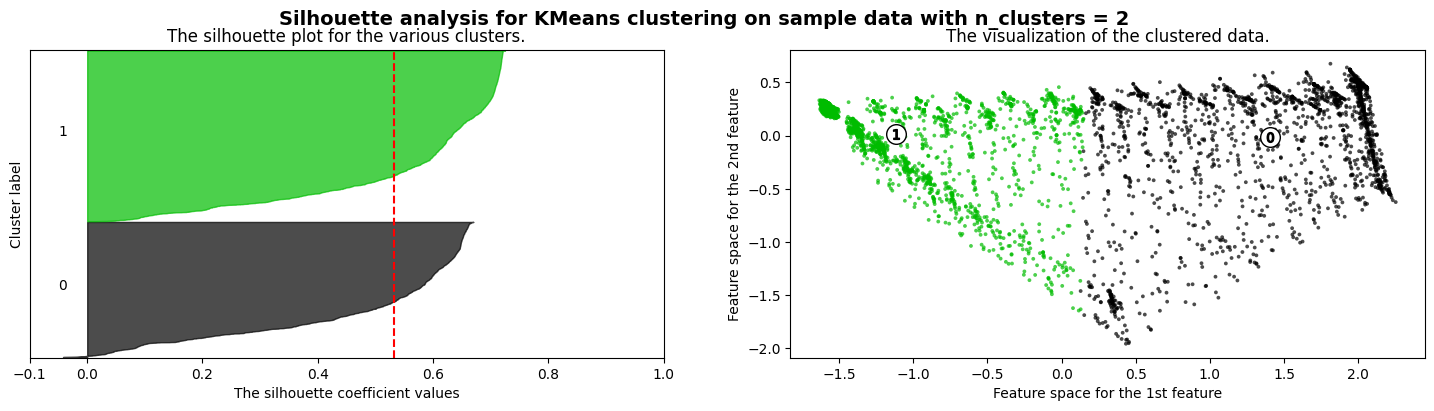

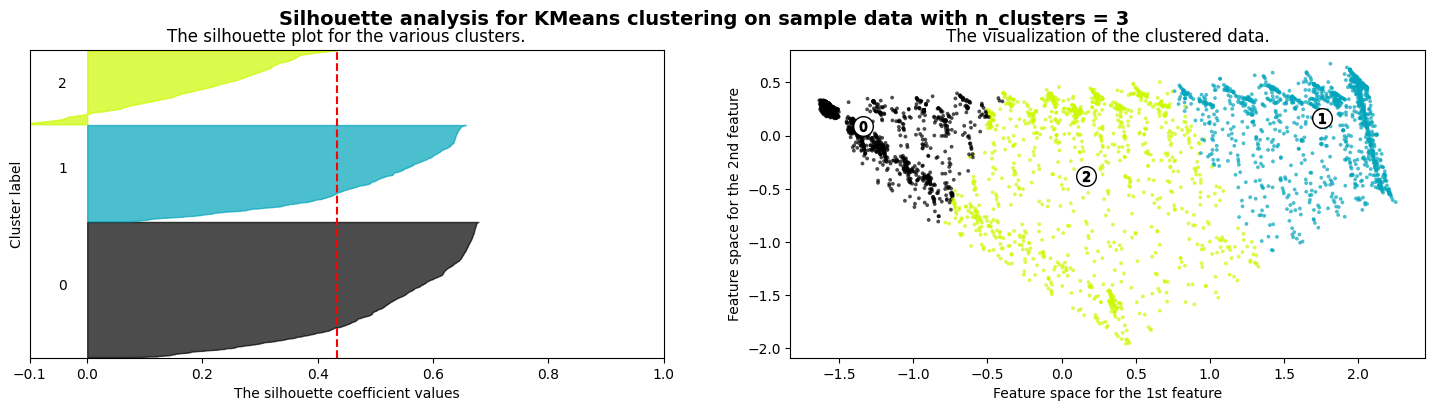

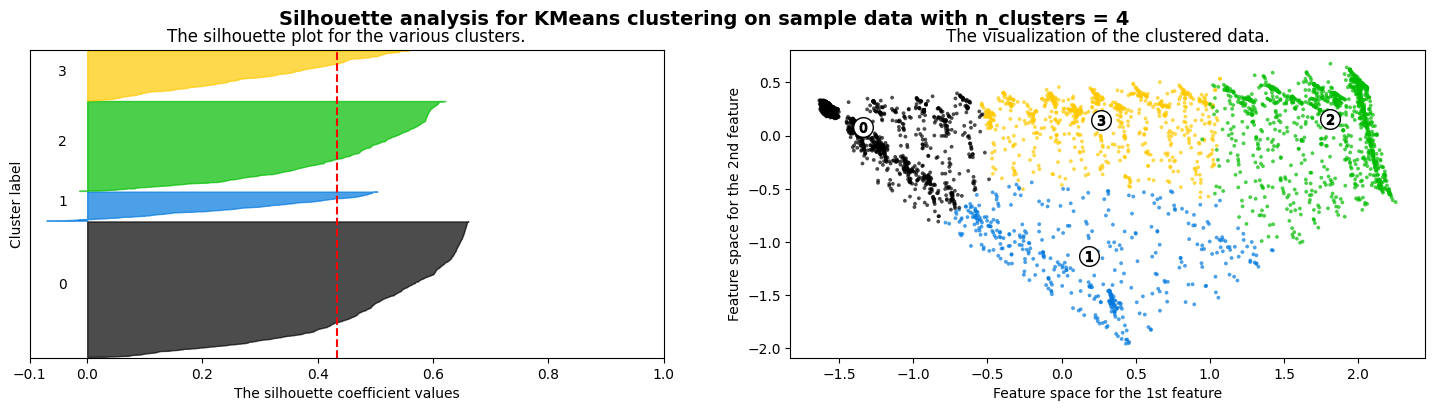

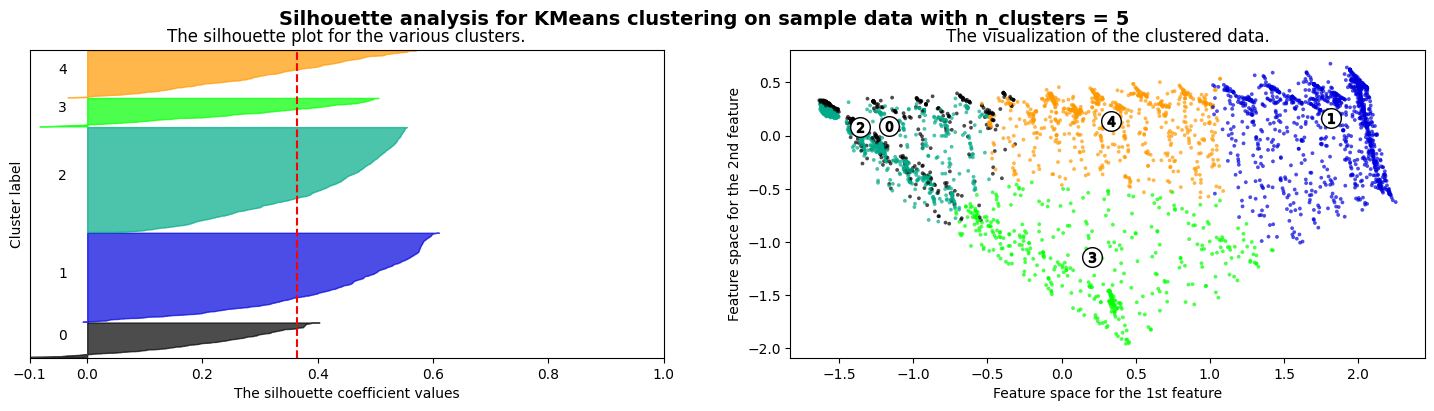

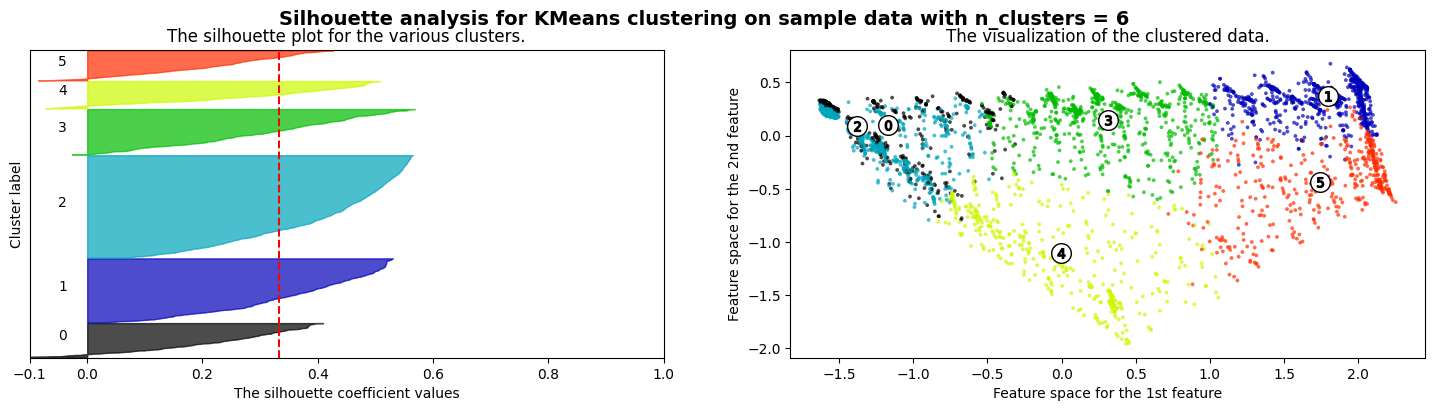

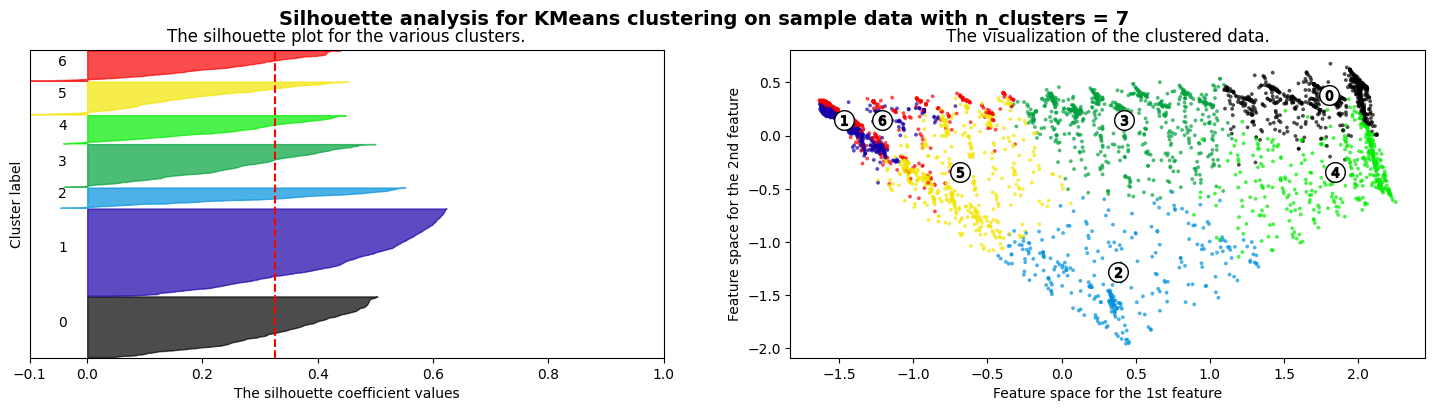

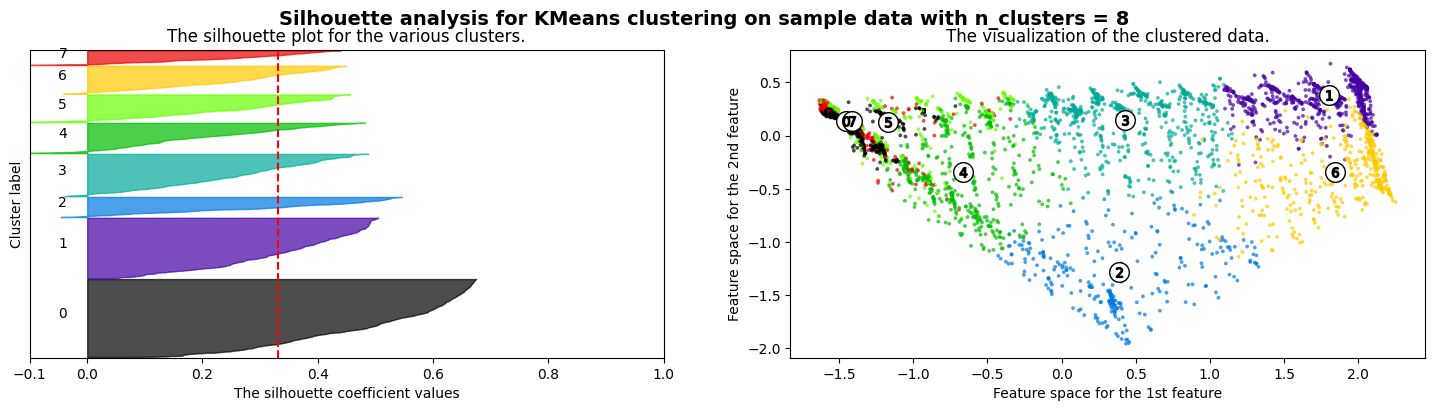

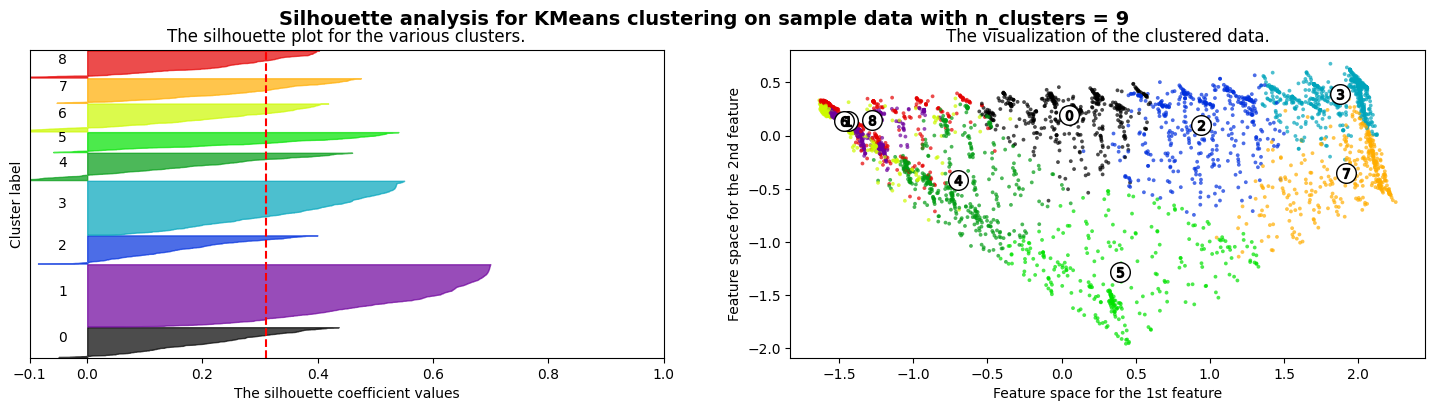

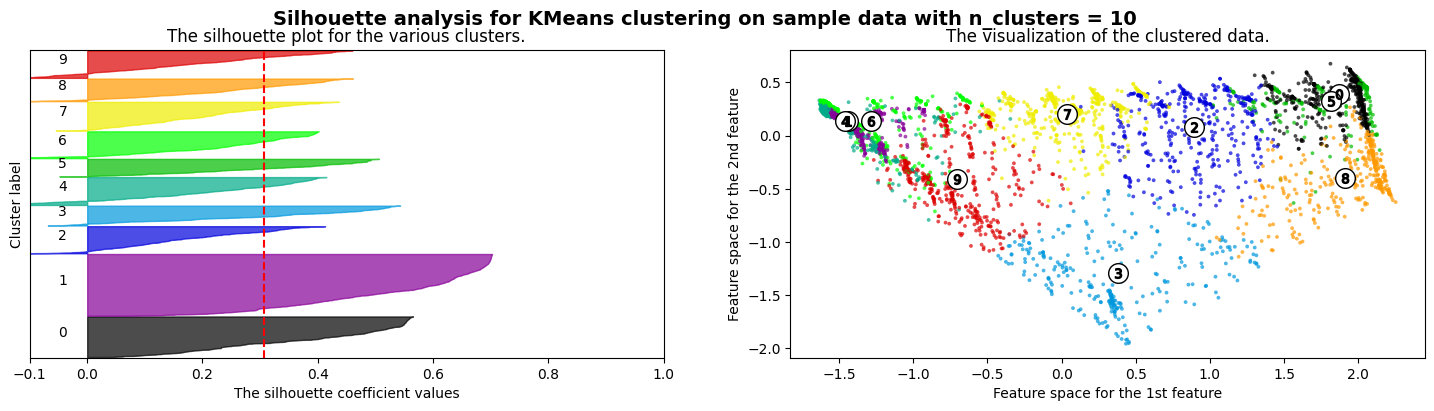

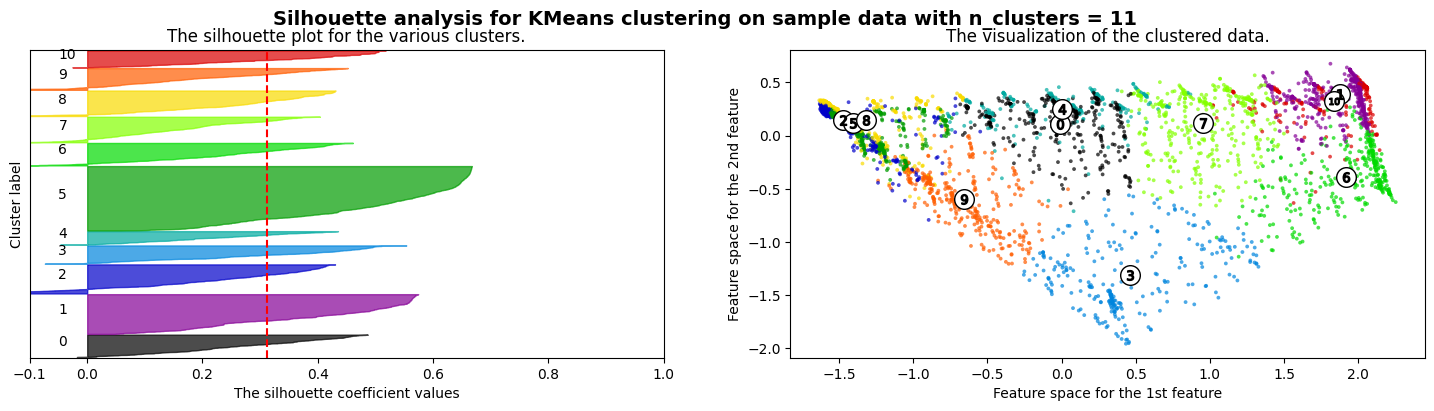

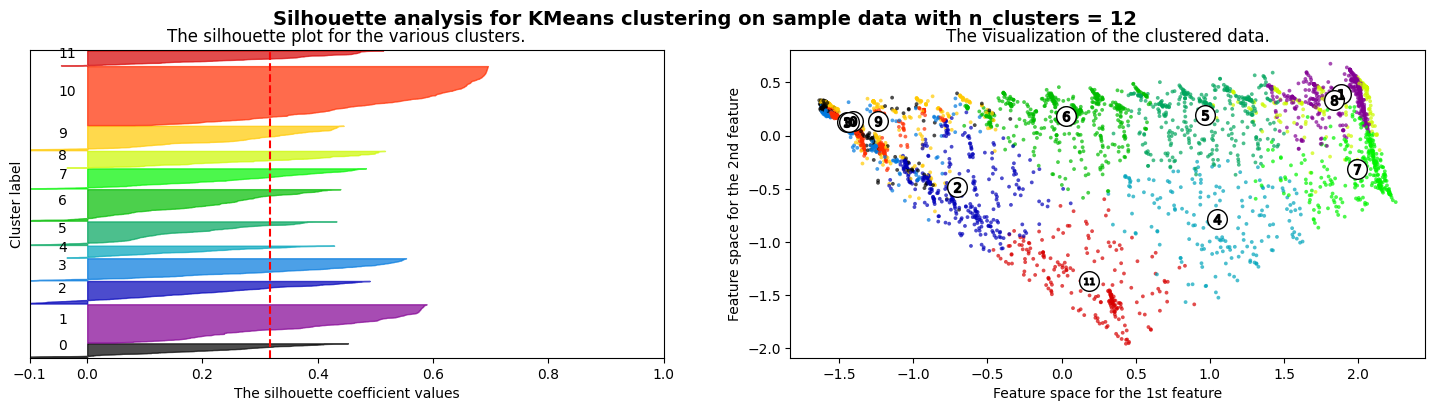

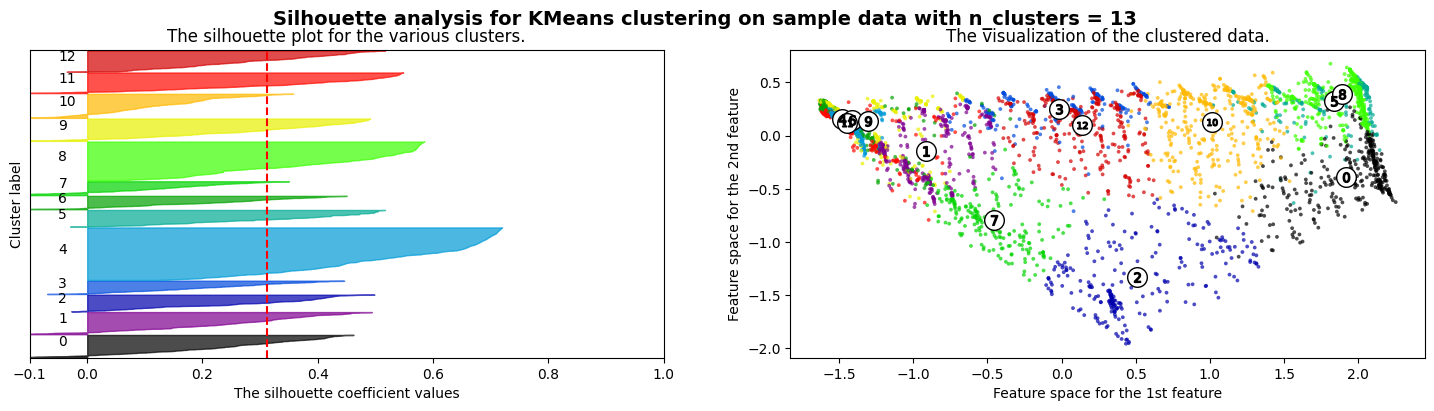

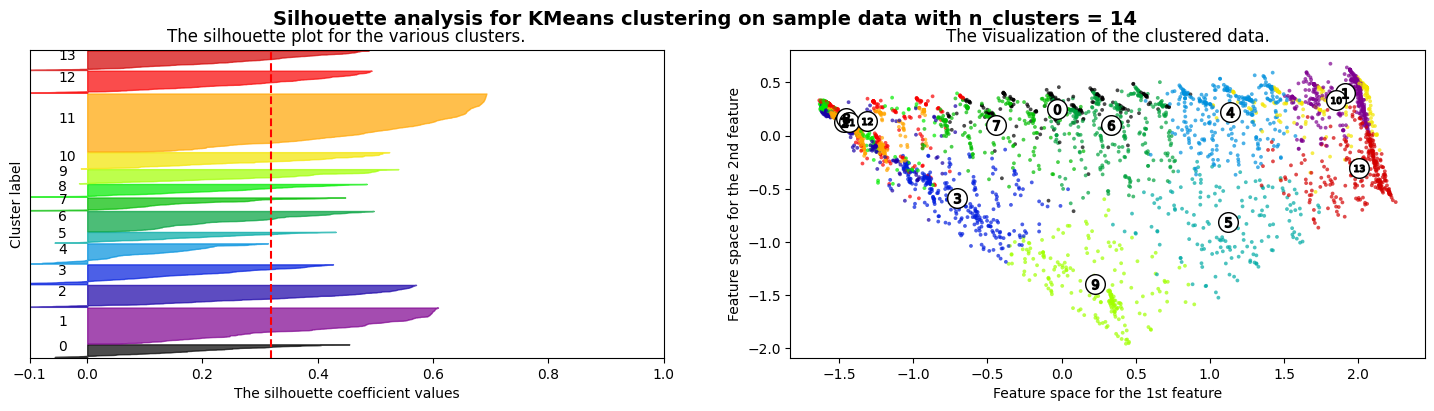

In [121]:
plot_silhouette(range(2, max_cluster), scaled_pca, random_state)

As can be seen from the silhouette plot above, 4 looks ideal compared to other silhouette plots, so we will go with 4 clusters, as concluded from elbow method and silhouette plot.

# **ix. Model Training**

> We will use KMeans to train with the optimal number of clusters, which is 4.

In [122]:
# Train with optimal number of clusters

km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = random_state)
pred = km.fit_predict(scaled_pca)
pred

array([0, 0, 0, ..., 1, 1, 2], dtype=int32)

In [123]:
credit_card_information_df['cluster'] = pred
credit_card_information_df

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0         788    16.581535           0.272727     200.00              0.00   
1        1902   943.584041           0.875000     103.00            103.00   
2        2322     1.979916           0.272727      80.00             80.00   
3        3426   461.455720           1.000000     585.00            585.00   
4        3976  1053.594730           1.000000    1450.00           1450.00   
...       ...          ...                ...        ...               ...   
4470     4630  1079.008102           1.000000       0.00              0.00   
4471     8614   809.582978           0.909091       0.00              0.00   
4472     4296  3386.490883           1.000000     560.98            427.22   
4473     4476  4840.545574           1.000000    1595.93           1595.93   
4474     3564  1977.007090           1.000000    1032.04            226.90   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                     200.00      0.000000             0.125000   
1                       0.00      0.000000             0.125000   
2                       0.00      0.000000             0.125000   
3                       0.00      0.000000             0.125000   
4                       0.00      0.000000             0.125000   
...                      ...           ...                  ...   
4470                    0.00   1259.571764             0.000000   
4471                    0.00   3819.672466             0.000000   
4472                  133.76   2008.153534             1.000000   
4473                    0.00   4359.325750             0.454545   
4474                  805.14   4335.919227             0.909091   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                       0.000000                          0.125000   
1                       0.125000                          0.000000   
2                       0.125000                          0.000000   
3                       0.125000                          0.000000   
4                       0.125000                          0.000000   
...                          ...                               ...   
4470                    0.000000                          0.000000   
4471                    0.000000                          0.000000   
4472                    0.727273                          0.363636   
4473                    0.454545                          0.000000   
4474                    0.090909                          0.818182   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                   0.000000                 0              2        1200.0   
1                   0.000000                 0              1        1000.0   
2                   0.000000                 0              1        1500.0   
3                   0.000000                 0              1        1000.0   
4                   0.000000                 0              1        1500.0   
...                      ...               ...            ...           ...   
4470                0.545455                 9              0        1200.0   
4471                0.545455                 7              0        4150.0   
4472                0.545455                 9             20       10100.0   
4473                0.545455                17             25        6000.0   
4474                0.545455                21             17        4000.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
0        0.000000        309.854995          0.000000       8        0  
1      215.325023        410.484825          0.000000       8        0  
2        0.000000        309.854995          0.000000       8        0  
3      258.032630        151.696433          0.000000       8        0  
4      397.090516        227.143184          0.000000       8        0  
...           ...               ... 

<Axes: >

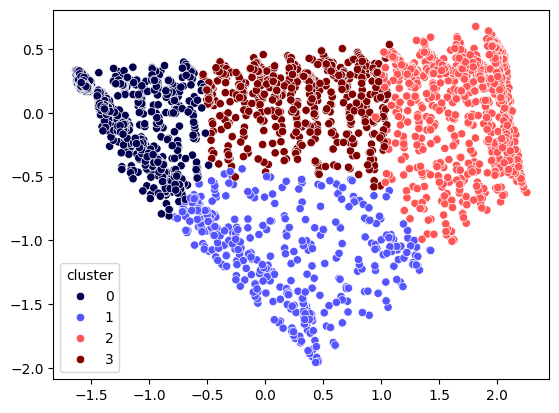

In [124]:
# Cluster visualization in 2D

pca_2d = PCA(n_components=2)
pca_2d.fit(scaled_pca)

credit_card_scaled_pca = pca_2d.fit_transform(scaled_pca)

sns.scatterplot(x=credit_card_scaled_pca[:,0], y=credit_card_scaled_pca[:,1], hue=credit_card_information_df['cluster'], palette='seismic')

From the KMeans model that we've created above, we can say that it has successfully identified 4 different groups. Although this looks good already, we can experiment with other clustering algorithms like DBSCAN or Gaussian Mixture Models (GMM) to compare different results. From the options of "k" that we have from silhouette plot and elbow method, I suggest that 4 would be the best fit for the KMeans "k" argument. The clusters appear reasonably compact, though there is a bit of spread in all directions. There doesn't seem to be extreme outliers or major anomalies in any cluster.

We will look at how many data there are per cluster.

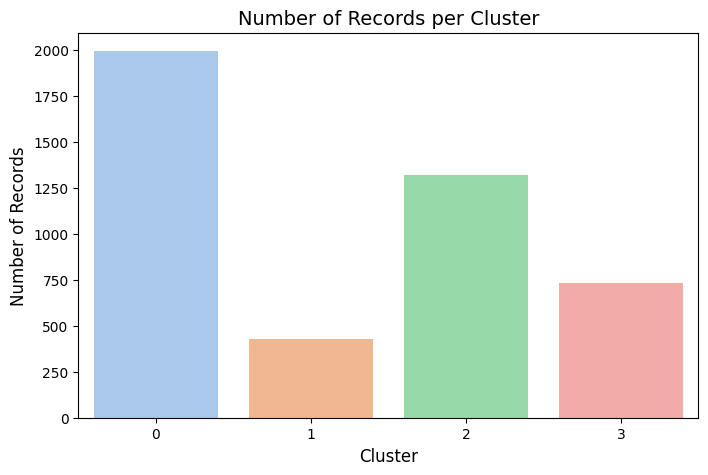

In [125]:
clusters = credit_card_information_df["cluster"].unique()
lengths = [len(credit_card_information_df[credit_card_information_df["cluster"] == clust]) for clust in clusters]

cluster_data = pd.DataFrame({'Cluster': clusters, 'Length': lengths})

# Create bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Cluster', y='Length', data=cluster_data, palette='pastel')

# Set titles and labels
plt.title('Number of Records per Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)

# Show the plot
plt.show()

As can be seen from the plot above, cluster 0 has the most rows, followed by cluster 2.

Now we will look at the comparison between columns and clusters. We will group them by the column names, as they seem to be related to each other.

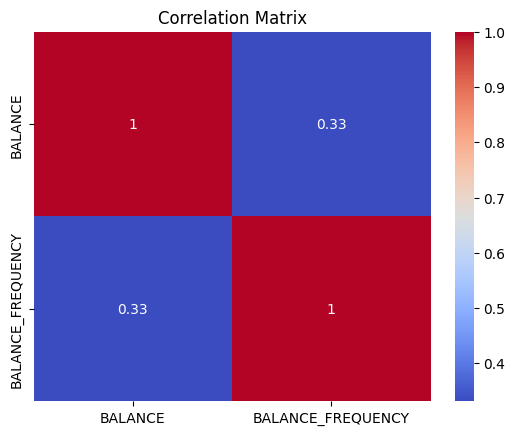

In [126]:
corr_matrix = credit_card_information_df[["BALANCE", "BALANCE_FREQUENCY"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

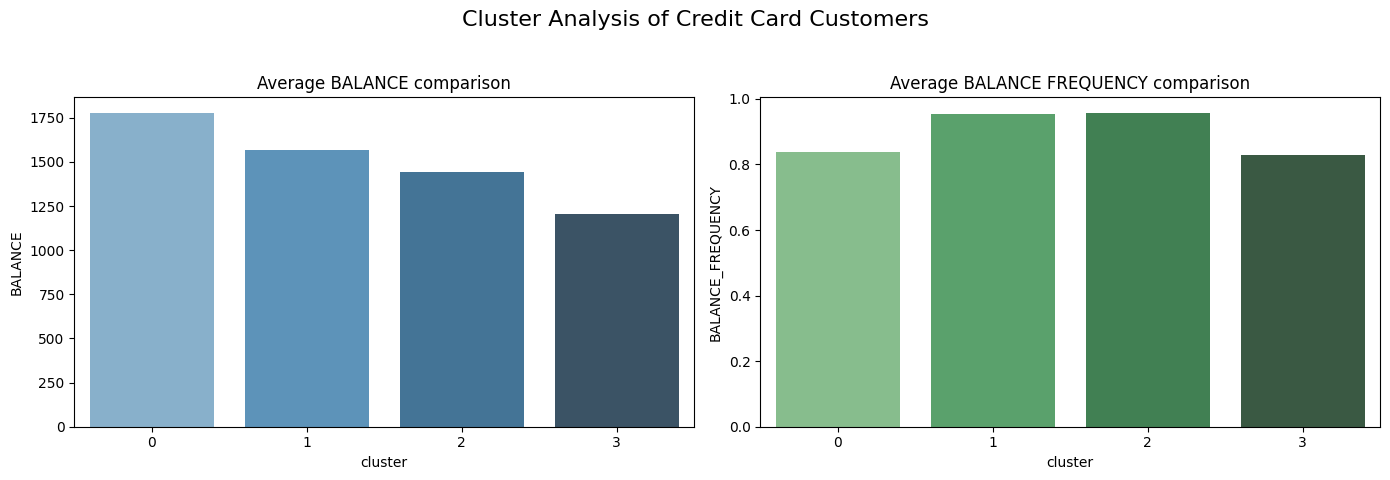

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Cluster Analysis of Credit Card Customers', fontsize=16)

# Balance
sns.barplot(x='cluster', y='BALANCE', data=credit_card_information_df, ax=axs[0], ci=None, palette='Blues_d')
axs[0].set_title('Average BALANCE comparison')

# Credit Limit
sns.barplot(x='cluster', y='BALANCE_FREQUENCY', data=credit_card_information_df, ax=axs[1], ci=None, palette='Greens_d')
axs[1].set_title('Average BALANCE FREQUENCY comparison')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

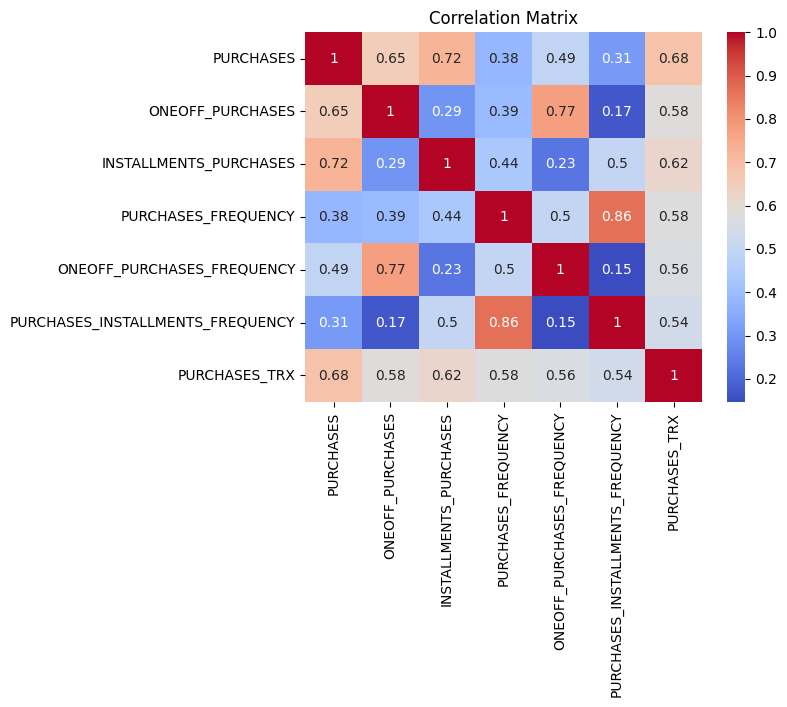

In [128]:
corr_matrix = credit_card_information_df[["PURCHASES", "ONEOFF_PURCHASES", "INSTALLMENTS_PURCHASES", "PURCHASES_FREQUENCY", "ONEOFF_PURCHASES_FREQUENCY", "PURCHASES_INSTALLMENTS_FREQUENCY", "PURCHASES_TRX"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

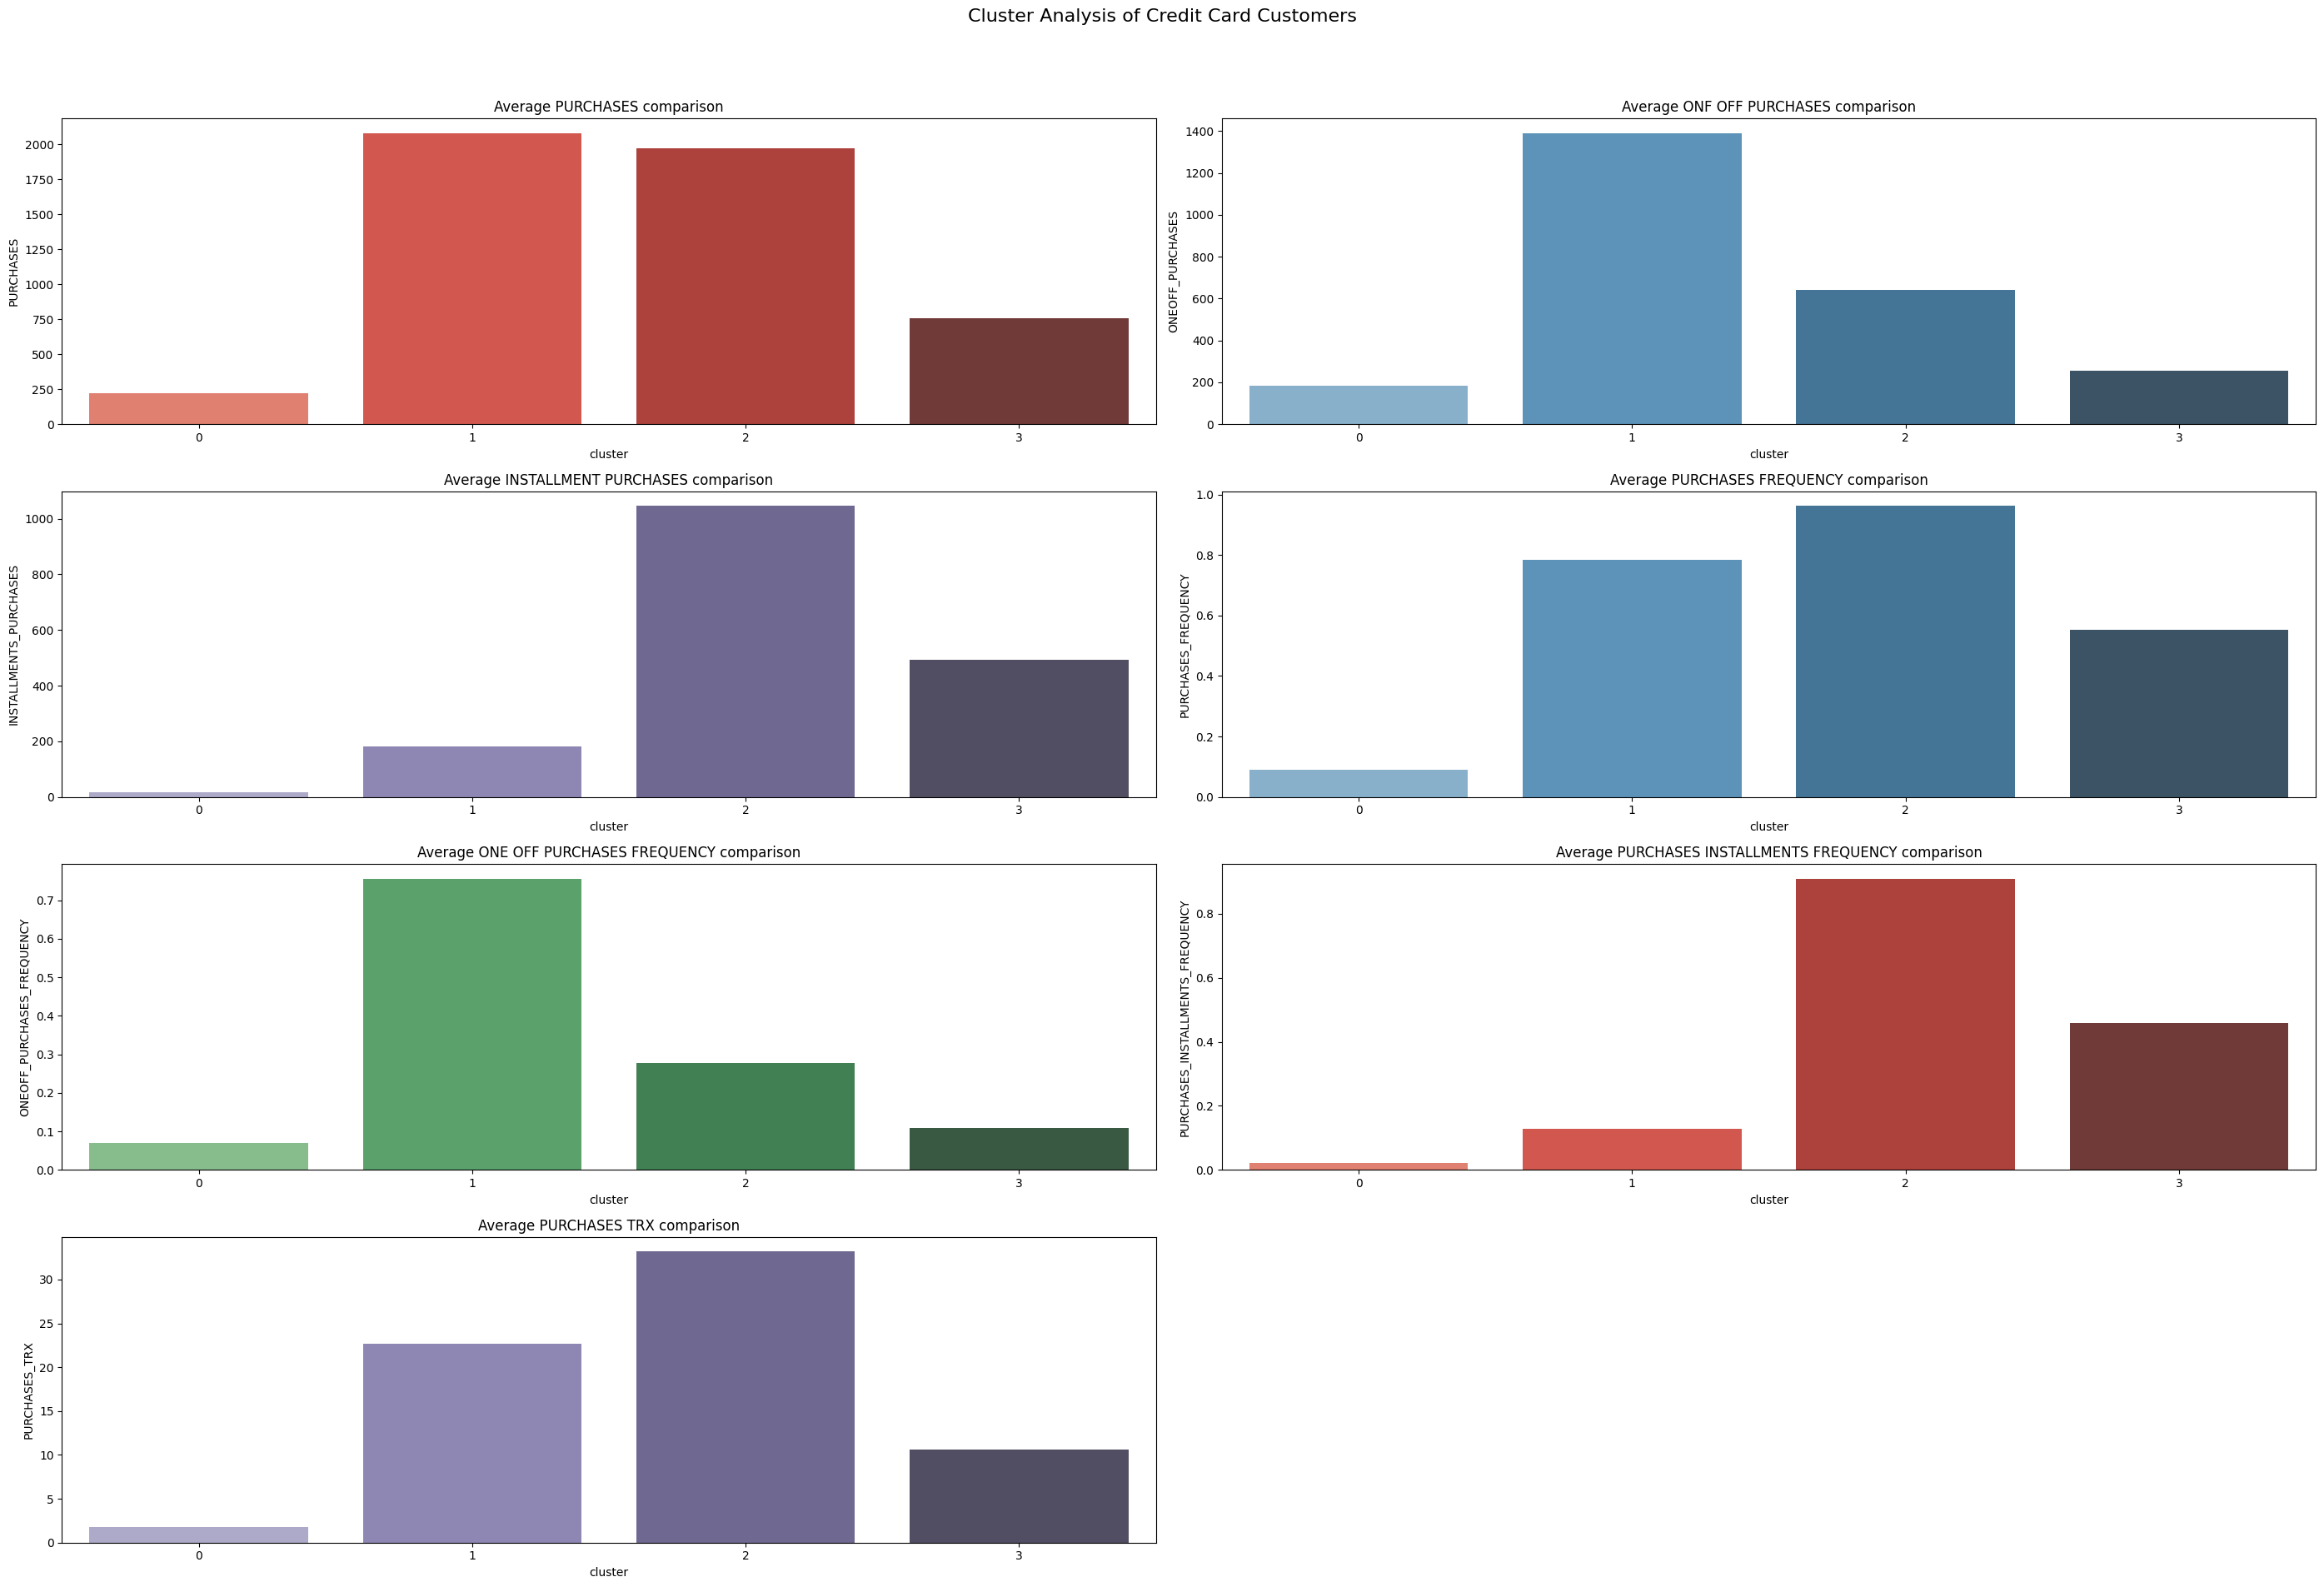

In [129]:
# Create subplots using seaborn
fig, axs = plt.subplots(4, 2, figsize=(28, 20))
fig.suptitle('Cluster Analysis of Credit Card Customers', fontsize=16)

# Purchases
sns.barplot(x='cluster', y='PURCHASES', data=credit_card_information_df, ax=axs[0, 0], ci=None, palette='Reds_d')
axs[0, 0].set_title('Average PURCHASES comparison')

# Minimum Payments
sns.barplot(x='cluster', y='ONEOFF_PURCHASES', data=credit_card_information_df, ax=axs[0, 1], ci=None, palette='Blues_d')
axs[0, 1].set_title('Average ONF OFF PURCHASES comparison')

# Purchases Frequency
sns.barplot(x='cluster', y='INSTALLMENTS_PURCHASES', data=credit_card_information_df, ax=axs[1, 0], ci=None, palette='Purples_d')
axs[1, 0].set_title('Average INSTALLMENT PURCHASES comparison')

# Balance
sns.barplot(x='cluster', y='PURCHASES_FREQUENCY', data=credit_card_information_df, ax=axs[1, 1], ci=None, palette='Blues_d')
axs[1, 1].set_title('Average PURCHASES FREQUENCY comparison')

# Credit Limit
sns.barplot(x='cluster', y='ONEOFF_PURCHASES_FREQUENCY', data=credit_card_information_df, ax=axs[2, 0], ci=None, palette='Greens_d')
axs[2, 0].set_title('Average ONE OFF PURCHASES FREQUENCY comparison')

# Purchases
sns.barplot(x='cluster', y='PURCHASES_INSTALLMENTS_FREQUENCY', data=credit_card_information_df, ax=axs[2, 1], ci=None, palette='Reds_d')
axs[2, 1].set_title('Average PURCHASES INSTALLMENTS FREQUENCY comparison')

# Purchases Frequency
sns.barplot(x='cluster', y='PURCHASES_TRX', data=credit_card_information_df, ax=axs[3, 0], ci=None, palette='Purples_d')
axs[3, 0].set_title('Average PURCHASES TRX comparison')


# Hide the empty subplot (for odd number of plots)
axs[3, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

As can be seen from the heatmap and barplots above, these 7 columns have strong correlations with each other.

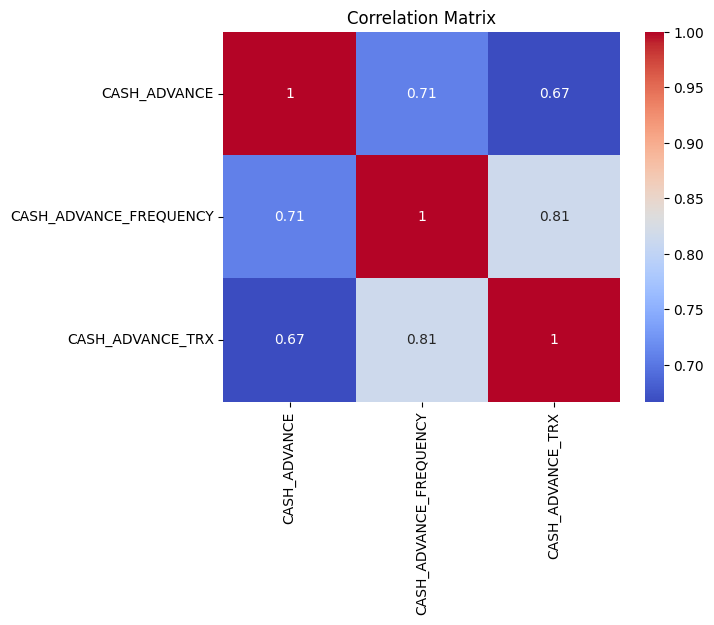

In [130]:
corr_matrix = credit_card_information_df[["CASH_ADVANCE", "CASH_ADVANCE_FREQUENCY", "CASH_ADVANCE_TRX"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

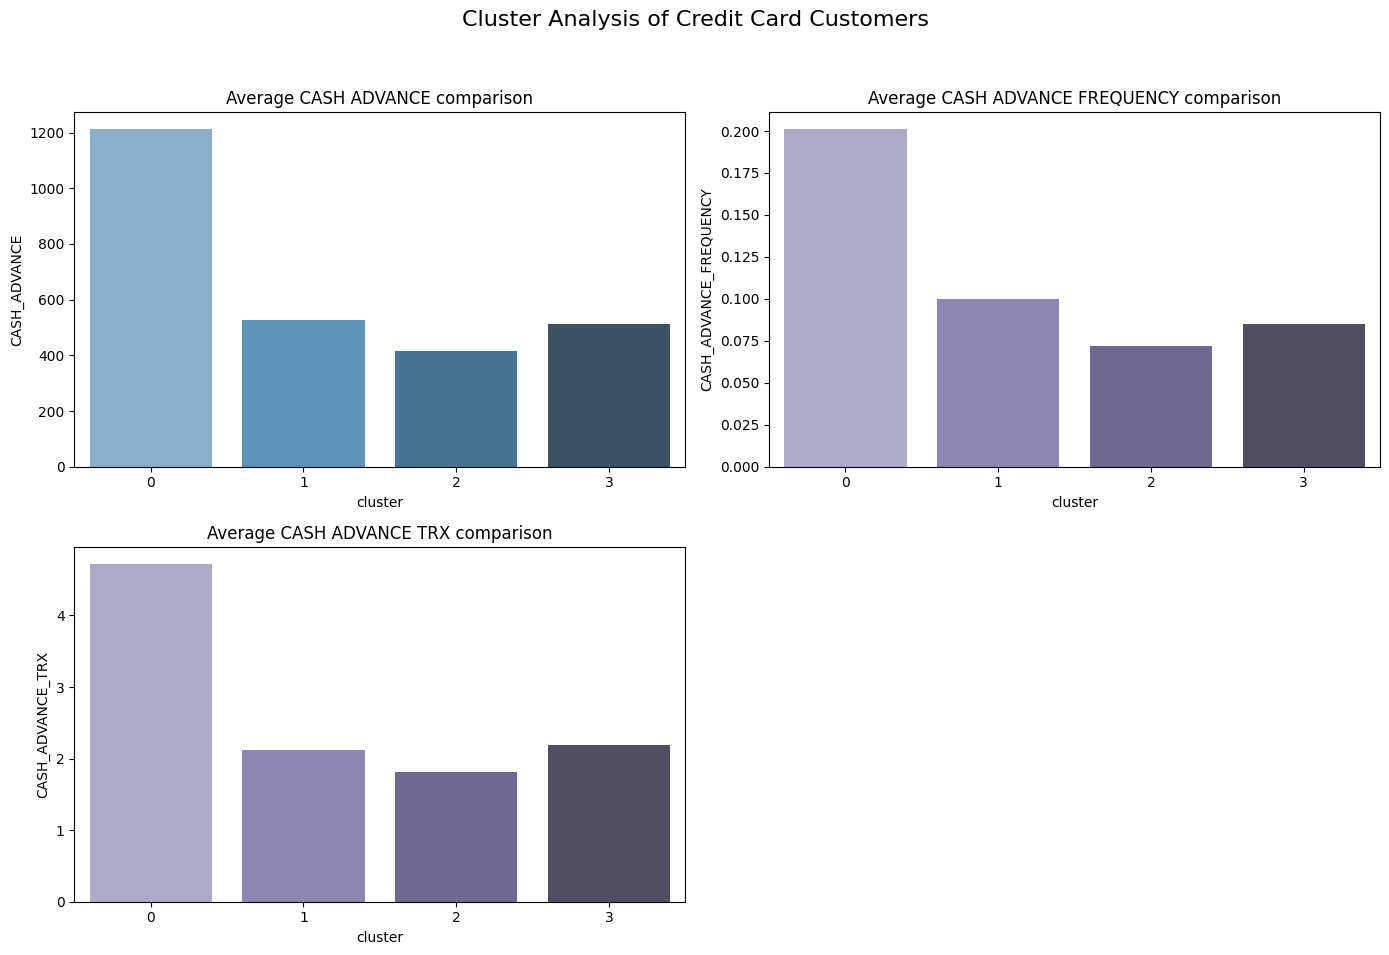

In [131]:
# Create subplots using seaborn
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Cluster Analysis of Credit Card Customers', fontsize=16)

# Average Cash Advance Plot
sns.barplot(x='cluster', y='CASH_ADVANCE', data=credit_card_information_df, ax=axs[0, 0], ci=None, palette='Blues_d')
axs[0, 0].set_title('Average CASH ADVANCE comparison')

# Average Cash Advance Frequency Plot
sns.barplot(x='cluster', y='CASH_ADVANCE_FREQUENCY', data=credit_card_information_df, ax=axs[0, 1], ci=None, palette='Purples_d')
axs[0, 1].set_title('Average CASH ADVANCE FREQUENCY comparison')

# Average Cash Advance TRX Plot
sns.barplot(x='cluster', y='CASH_ADVANCE_TRX', data=credit_card_information_df, ax=axs[1, 0], ci=None, palette='Purples_d')
axs[1, 0].set_title('Average CASH ADVANCE TRX comparison')

# Hide the empty subplot (for odd number of plots)
axs[1, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

As can be seen from the heatmap and barplots above, these 3 columns have strong correlations with each other.

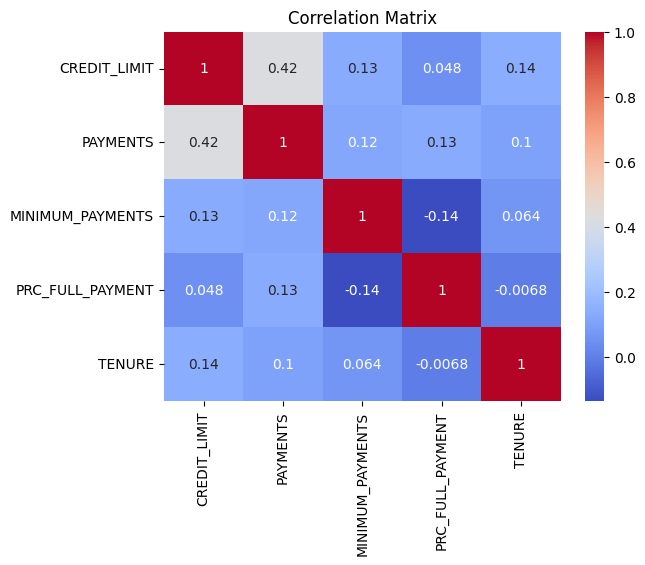

In [132]:
corr_matrix = credit_card_information_df[["CREDIT_LIMIT", "PAYMENTS", "MINIMUM_PAYMENTS", "PRC_FULL_PAYMENT", "TENURE"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

For these 5 columns, they have weak correlations with each other.

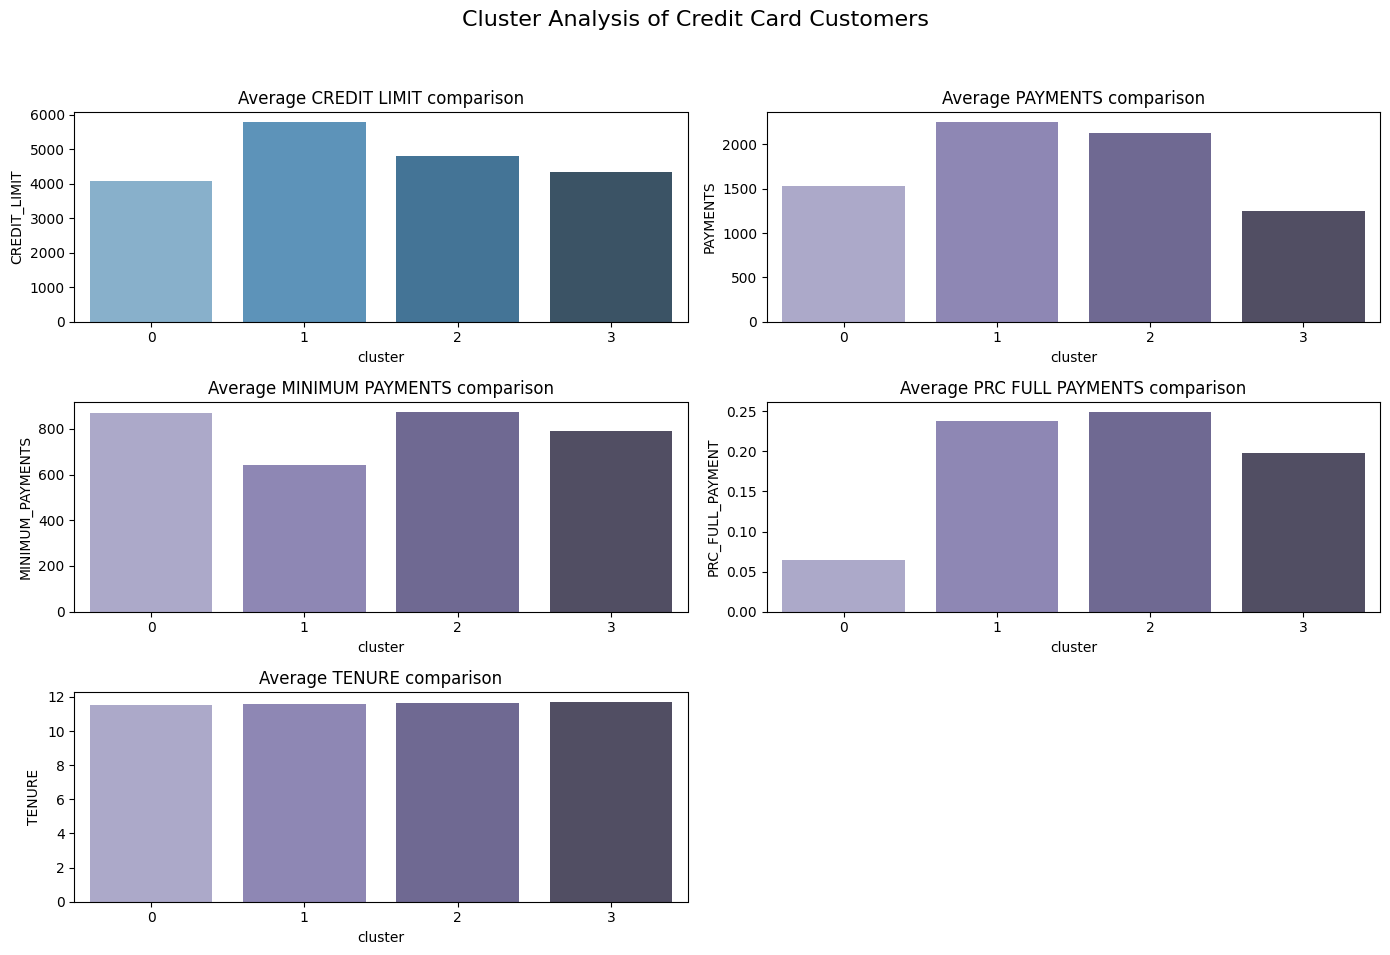

In [133]:
# Create subplots using seaborn
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Cluster Analysis of Credit Card Customers', fontsize=16)

# Minimum Payments
bar_plot_1 = sns.barplot(x='cluster', y='CREDIT_LIMIT', data=credit_card_information_df, ax=axs[0, 0], ci=None, palette='Blues_d')
axs[0, 0].set_title('Average CREDIT LIMIT comparison')

# Purchases Frequency
sns.barplot(x='cluster', y='PAYMENTS', data=credit_card_information_df, ax=axs[0, 1], ci=None, palette='Purples_d')
axs[0, 1].set_title('Average PAYMENTS comparison')

# Purchases Frequency
sns.barplot(x='cluster', y='MINIMUM_PAYMENTS', data=credit_card_information_df, ax=axs[1, 0], ci=None, palette='Purples_d')
axs[1, 0].set_title('Average MINIMUM PAYMENTS comparison')

# Purchases Frequency
sns.barplot(x='cluster', y='PRC_FULL_PAYMENT', data=credit_card_information_df, ax=axs[1, 1], ci=None, palette='Purples_d')
axs[1, 1].set_title('Average PRC FULL PAYMENTS comparison')

# Purchases Frequency
sns.barplot(x='cluster', y='TENURE', data=credit_card_information_df, ax=axs[2, 0], ci=None, palette='Purples_d')
axs[2, 0].set_title('Average TENURE comparison')

# Hide the empty subplot (for odd number of plots)
axs[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

As can be seen from the plots above, there is not much significant difference between each cluster in terms of `balance`. From the `purchasing` behaviour, it can be seen that cluster 2 is the most active, as it has the highest average `installment purchases`, `installment frequency`, `purchases frequency` and `purchases TRX`, while cluster 0 is the most passive, with the lowest average values in all the `purchases` columns. Cluster 1 has lots of `one off purchases` and `one off purchases frequencies`. However, even though cluster 2 seems to have lots of `installment purchases`, `installment frequency`, `purchases frequency` and `purchases TRX`, cluster 1 still has the higher `average purchases` by little margin. That means that although cluster 1 does a lot of `one off purchases`, they do so with more expensive items, hence the amount of `purchases` is high. With this, we can give our business recommendations for each customer cluster.

- Cluster 1: Makes a lot of one-off purchases but spends significant amounts. This means that this customer segment expect high-quality service. We can invest in VIP-like customer service to build trust and offer tailored experiences or products, to make the purchase feel special. Hopefully we can turn one-off buyers into repeat customers.
- Cluster 0: High frequency of cash being paid in advance, but spends low amounts. This means that this customer segment does a lot of payment, but do so in small amount of money. We can create a loyalty program that rewards frequent customers with discounts, points or perks after a certain number of purchases. This will encourage customers to keep coming back. We can also offer tiered rewards where customers who make frequent payments can unlock higher levels of benefits, such as free products, upgraded services, or priority customer service.
- Cluster 2: Makes a lot of purchases, but spends low or average amounts. For this customer segment, we can offer them customer experience enhancement, such as faster shipping or priority customer support. This makes them feel valued and can encourage brand loyalty. 
- Cluster 3: This customer segment is the segment between Cluster 1 and Cluster 2, so we have to have a balanced approach. We can give them hybrid loyalty program that balances both frequency and value of purchases. Customers earn points based on the amount spent or the frequency of purchases, allowing them to accumulate points faster for higher-value transactions.

In [134]:
pipe = Pipeline([
    ('winsoriser', Winsorizer(capping_method='quantiles',
                            tail='both',
                            fold=0.05,
                            variables=cols_to_cap,
                            missing_values='ignore')),
    ('skewed_scaler', MinMaxScaler(), skewed_col), 
    ('normal_scaler', StandardScaler(), normal_col),
    ('pca', PCA(n_components=2))
])

# xi. Model Saving

In [135]:
joblib.dump(km, 'model.pkl')
joblib.dump(pipe, 'pipeline.pkl')
joblib.dump(credit_card_original.columns.to_list(), 'num_cols.pkl')

['num_cols.pkl']

# xii. Model Inference

In [136]:
#load pipeline
pipeline = joblib.load('pipeline.pkl')
#load model
model = joblib.load('model.pkl')
#load list nama kolom
num_cols = joblib.load('num_cols.pkl')

In [137]:
df_dict = credit_card_original.sample(5).to_dict(orient='list')
df_dict

{'CUST_ID': [2356, 1900, 7964, 1494, 4854],
 'BALANCE': [687.004441, 512.058666, 778.393346, 988.405365, 1839.122533],
 'BALANCE_FREQUENCY': [1.0, 0.818182, 1.0, 1.0, 1.0],
 'PURCHASES': [252.0, 921.2, 1854.3, 637.97, 1055.32],
 'ONEOFF_PURCHASES': [0.0, 664.73, 174.4, 45.65, 0.0],
 'INSTALLMENTS_PURCHASES': [252.0, 256.47, 1679.9, 592.32, 1055.32],
 'CASH_ADVANCE': [1748.90582, 0.0, 0.0, 38.322217, 3780.152602],
 'PURCHASES_FREQUENCY': [1.0, 0.416667, 1.0, 1.0, 0.916667],
 'ONEOFF_PURCHASES_FREQUENCY': [0.0, 0.166667, 0.083333, 0.083333, 0.0],
 'PURCHASES_INSTALLMENTS_FREQUENCY': [0.888889, 0.25, 1.0, 1.0, 0.833333],
 'CASH_ADVANCE_FREQUENCY': [0.555556, 0.0, 0.0, 0.083333, 0.25],
 'CASH_ADVANCE_TRX': [11, 0, 0, 1, 3],
 'PURCHASES_TRX': [9, 7, 26, 25, 19],
 'CREDIT_LIMIT': [2000.0, 5500.0, 1200.0, 1000.0, 6500.0],
 'PAYMENTS': [436.870246, 1851.553319, 844.459124, 864.471651, 2842.037627],
 'MINIMUM_PAYMENTS': [152.19372,
  786.58816,
  717.606248,
  903.567225,
  541.368131],
 'PRC_F

In [138]:
data= {'CUST_ID': [4514, 2236, 2114, 1600, 3086],
 'BALANCE': [31.111548, 144.555083, 369.384435, 208.131845, 936.370785],
 'BALANCE_FREQUENCY': [1.0, 0.363636, 1.0, 1.0, 1.0],
 'PURCHASES': [110.0, 1352.1, 3303.03, 2161.38, 158.45],
 'ONEOFF_PURCHASES': [110.0, 1352.1, 87.9, 451.5, 158.45],
 'INSTALLMENTS_PURCHASES': [0.0, 0.0, 3215.13, 1709.88, 0.0],
 'CASH_ADVANCE': [0.0, 0.0, 0.0, 0.0, 0.0],
 'PURCHASES_FREQUENCY': [0.083333, 0.166667, 0.833333, 1.0, 0.25],
 'ONEOFF_PURCHASES_FREQUENCY': [0.083333, 0.166667, 0.166667, 0.166667, 0.25],
 'PURCHASES_INSTALLMENTS_FREQUENCY': [0.0, 0.0, 0.75, 1.0, 0.0],
 'CASH_ADVANCE_FREQUENCY': [0.0, 0.0, 0.0, 0.0, 0.0],
 'CASH_ADVANCE_TRX': [0, 0, 0, 0, 0],
 'PURCHASES_TRX': [1, 3, 28, 41, 3],
 'CREDIT_LIMIT': [8000.0, 2500.0, 6000.0, 4500.0, 1700.0],
 'PAYMENTS': [228.192095, 656.758103, 2353.184431, 2059.879468, 160.698863],
 'MINIMUM_PAYMENTS': [73.146612, 77.571584, 173.56131, 165.05215, 443.538283],
 'PRC_FULL_PAYMENT': [0.0, 0.0, 0.0, 1.0, 0.0],
 'TENURE': [12, 12, 12, 12, 12]}

df_inf = pd.DataFrame(data)

# xiii. Conclusion

The conclusion is that we have successfully segmented the data with 4 different customer groups by using KMeans as the clustering algorithm. We have done dimensionality reduction, EDAs, missing value handling and outlier handling. There are EDAs done before clustering and after clustering. We did Dimensionality Reduction and used elbow method and silhouette score & plot to determine the ideal number of clusters.

Each segment has its characteristics and uniqueness. We have to understand the characteristics and personalities of each segment, and treat each of them differently. That way, our business can progress in a more strategical way.

- Cluster 1: Makes a lot of one-off purchases but spends significant amounts.
- Cluster 0: High frequency of cash being paid in advance, but spends low amounts.
- Cluster 2: Makes a lot of purchases, but spends low or average amounts. 
- Cluster 3: This customer segment is the segment between Cluster 1 and Cluster 2, so we have to have a balanced approach.

Further Model recommendation: Try with other algorithms such as DBSCAN or Gaussian Mixture Models (GMM) to compare different results.

Business recommendation: Focus more on customers in cluster 1 and 2, as they do the highest amount of purchases. Cluster 0 has little impact in terms of purchases amount, so that cluster can be ignored for now. We can have more engagement with customers in cluster 1 and 2 such as giving them loyalty and reward programs, and personalized marketing and offers, to make them feel satisfied, listened to and will trigger more purchases.